In [ ]:
from notebooks import *
print_sys_info()

platform:
  machine: x86_64
  node: fce99aa4c119
  processor: x86_64
  release: 4.14.33+
  system: Linux
  version: '#1 SMP Wed Jun 20 01:15:52 PDT 2018'
cpu: 16
mem: 102g
swap: 0g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[05:58:13.279] DEBUG  Projection.load
  path: /app/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
recs_at_least, num_species, num_recs =  20, 168,  20    # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  50   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  10   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          334/35236 (sp/recs)
(downloaded)       334/35228 (sp/recs)
recs_at_least      296/34842 (sp/recs)
num_species        168/19638 (sp/recs)


num_recs            168/3360 (sp/recs)
recs ≥ 2            168/3360 (sp/recs)


'sp[168], recs[3360]'

min  \
               dtype          sizeof len  count nunique mean        std                                                        
downloaded     bool           94080  3360 3360  1       NaN         NaN                                                 True   
species        category       178080 3360 3360  168     NaN         NaN                                                 GWFG   
id             int64          94080  3360 3360  3360     213310.169 108044.426                                          1133   
sci_name       category       227200 3360 3360  168     NaN         NaN                                      Anser albifrons   
com_name       category       220320 3360 3360  168     NaN         NaN                          Greater White-fronted Goose   
subspecies     object         169597 3360 3360  206     NaN         NaN                                                        
recordist      object         211704 3360 3360  291     NaN         NaN                                              AJ Knue   
country        object         203070 3360 3360  3       NaN         NaN                                               Canada   
locality       object         316498 3360 3360  1741    NaN         NaN                Bahía la Ventosa, Salina Cruz, Oaxaca   
lat            float64        80640  3360 3308  1769     37.891     9.895                                               15.6   
lng            float64        80640  3360 3308  1783    -107.703    19.352                                              -177   
type           object         191622 3360 3360  338     NaN         NaN                                   "chekurrrrrr" call   
quality        category       194711 3360 3360  6       NaN         NaN                                                    A   
date           datetime64[ns] 430080 3360 3360  1567    NaN         NaN                                  1985-06-25 00:00:00   
time           object         180924 3360 3360  894     NaN         NaN                                                    ?   
license_type   category       191388 3360 3360  3       NaN         NaN                                             by-nc-nd   
license_detail category       174720 3360 3360  3       NaN         NaN                                                  2.5   
license        object         312348 3360 3360  7       NaN         NaN         //creativecommons.org/licenses/by-nc-nd/2.5/   
url            object         275035 3360 3360  3360    NaN         NaN                    https://www.xeno-canto.org/100121   
download       object         285115 3360 3360  3360    NaN         NaN                 //www.xeno-canto.org/100121/download   

                                                                                                                                25%  \
               dtype          sizeof len  count nunique mean        std                                                               
downloaded     bool           94080  3360 3360  1       NaN         NaN                                                        True   
species        category       178080 3360 3360  168     NaN         NaN                                                        GBTE   
id             int64          94080  3360 3360  3360     213310.169 108044.426                                               138144   
sci_name       category       227200 3360 3360  168     NaN         NaN                                       Gelochelidon nilotica   
com_name       category       220320 3360 3360  168     NaN         NaN                                            Gull-billed Tern   
subspecies     object         169597 3360 3360  206     NaN         NaN                                                               
recordist      object         211704 3360 3360  291     NaN         NaN                                               Frank Lambert   
country        object         203070 3360 3360  3       NaN         NaN                  

downloaded species      id               sci_name                 com_name    subspecies           recordist  \
species                                                                                                                        
COGA    205189        True    COGA  207451      Gallinula galeata         Common Gallinule  sandvicensis       Ross Gallardy   
INDO    18832         True    INDO  398616         Columbina inca                Inca Dove                  Manuel Grosselet   
EWPW    223194        True    EWPW  188611  Antrostomus vociferus   Eastern Whip-poor-will                 David Jonas Weber   
NUWO    113835        True    NUWO  301366     Picoides nuttallii     Nuttall's Woodpecker                      Denise Wight   
BBWO    80808         True    BBWO  335436      Picoides arcticus  Black-backed Woodpecker                Lance A. M. Benner   
HUVI    117936        True    HUVI  297126          Vireo huttoni           Hutton's Vireo                       Paul Marvin   
MGWA    89731         True    MGWA  326299     Geothlypis tolmiei   MacGillivray's Warbler                Lance A. M. Benner   
PUFI    159786        True    PUFI  254326   Haemorhous purpureus             Purple Finch                              Iain   
CAFI    46804         True    CAFI  369971    Haemorhous cassinii           Cassin's Finch                      Eric DeFonso   
AMGO    256886        True    AMGO  153552         Spinus tristis       American Goldfinch                  Mike Schanbacher   

                      country                                                                    locality     lat      lng  \
species                                                                                                                      
COGA    205189  United States                                             Kailua, Honolulu County, Hawaii  21.391 -157.743   
INDO    18832          Mexico                                 Lomas de Bezares Miguel Hidalgo Mexico city  19.391  -99.244   
EWPW    223194  United States                                 Gravelly Hill Rd., Salem County, New Jersey  39.495  -75.355   
NUWO    113835  United States                                     Moraga, Contra Costa County, California  37.832 -122.134   
BBWO    80808   United States                              Blackrock Trailhead, Tulare County, California  36.175 -118.270   
HUVI    117936  United States                            Kickapoo Cavern State Park, Brackettville, Texas  29.618 -100.451   
MGWA    89731   United States  Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California  34.346 -117.915   
PUFI    159786         Canada                             Algonquin Highlands, Haliburton County, Ontario  45.306  -78.809   
CAFI    46804   United States          Dunton Rd area, San Juan National Forest, Dolores County, Colorado  37.780 -108.040   
AMGO    256886  United States                                         Falmouth, Barnstable, Massachusetts  41.522  -70.668   

                                         type   quality       date   time license_type license_detail  \
species                                                                                                 
COGA    205189                           call         B 2014-12-21  07:30     by-nc-sa            4.0   
INDO    18832                            song         B 2018-01-07  08:00     by-nc-sa            4.0   
EWPW    223194                           song         C 2014-07-25  05:30     by-nc-sa            4.0   
NUWO    113835  Hawk mobbing call, alarm call         C 2016-01-25  10:00     by-nc-sa            4.0   
BBWO    80808                  drumming, male  no score 2016-09-17  16:41     by-nc-sa            4.0   
HUVI    117936                           song         C 2012-04-08  07:58     by-nc-sa            4.0   
MGWA    89731                      male, song  no score 2016-06-28  10:49     by-nc-sa            4.0   
PUFI    159786       

In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

3360

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

min  \
                 dtype    sizeof len  count nunique mean      std                                             
dataset          object   171156 3356 3356  1       NaN       NaN                                        xc   
species          category 177868 3356 3356  168     NaN       NaN                                      GWFG   
species_com_name category 218906 3356 3356  168     NaN       NaN               Greater White-fronted Goose   
species_query    object   177868 3356 3356  168     NaN       NaN                                      ACWO   
duration_s       float64  80544  3356 3356  3052    5.424e+01 7.032e+01                               0.697   
samples_mb       float64  80544  3356 3356  3053    2.295e+00 2.973e+00                              0.0293   
samples_n        int64    93968  3356 3356  3053    1.203e+06 1.559e+06                               15368   
basename         object   181224 3356 3356  1       NaN       NaN                                     audio   
species_longhand category 242398 3356 3356  168     NaN       NaN        Greater White-fronted Goose - GWFG   
id               object   247859 3356 3356  3356    NaN       NaN                 xc/data/ACWO/153315/audio   
path             object   261283 3356 3356  3356    NaN       NaN             xc/data/ACWO/153315/audio.mp3   

                                                                                                  25%  \
                 dtype    sizeof len  count nunique mean      std                                       
dataset          object   171156 3356 3356  1       NaN       NaN                                  xc   
species          category 177868 3356 3356  168     NaN       NaN                                GBTE   
species_com_name category 218906 3356 3356  168     NaN       NaN                    Gull-billed Tern   
species_query    object   177868 3356 3356  168     NaN       NaN                                CONI   
duration_s       float64  80544  3356 3356  3052    5.424e+01 7.032e+01                          14.4   
samples_mb       float64  80544  3356 3356  3053    2.295e+00 2.973e+00                         0.607   
samples_n        int64    93968  3356 3356  3053    1.203e+06 1.559e+06                        318275   
basename         object   181224 3356 3356  1       NaN       NaN                               audio   
species_longhand category 242398 3356 3356  168     NaN       NaN             Gull-billed Tern - GBTE   
id               object   247859 3356 3356  3356    NaN       NaN            xc/data/CONI/77147/audio   
path             object   261283 3356 3356  3356    NaN       NaN        xc/data/CONI/77147/audio.mp3   

                                                                                                  50%  \
                 dtype    sizeof len  count nunique mean      std                                       
dataset          object   171156 3356 3356  1       NaN       NaN                                  xc   
species          category 177868 3356 3356  168     NaN       NaN                                REVI   
species_com_name category 218906 3356 3356  168     NaN       NaN                      Red-eyed Vireo   
species_query    object   177868 3356 3356  168     NaN       NaN                                LBCU   
duration_s       float64  80544  3356 3356  3052    5.424e+01 7.032e+01                          31.8   
samples_mb       float64  80544  3356 3356  3053    2.295e+00 2.973e+00                          1.34   
samples_n        int64    93968  3356 3356  3053    1.203e+06 1.559e+06                        702144   
basename         object   181224 3356 3356  1       NaN       NaN                               audio   
species_longhand category 242398 3356 3356  168     NaN       NaN               Red-eyed Vireo - REVI   
id               object   247859 3356 3356  3356    NaN       NaN            xc/data/LBCU/13611/audio   
path             object   261283 3

dataset species             species_com_name species_query  duration_s  samples_mb  samples_n basename  \
0      xc    GWFG  Greater White-fronted Goose          GWFG      23.712       0.997     522850    audio   
1      xc    GWFG  Greater White-fronted Goose          GWFG      18.312       0.770     403780    audio   
2      xc    GWFG  Greater White-fronted Goose          GWFG      44.957       1.891     991296    audio   
3      xc    GWFG  Greater White-fronted Goose          GWFG      17.554       0.738     387072    audio   
4      xc    GWFG  Greater White-fronted Goose          GWFG      23.952       1.007     528142    audio   

                     species_longhand                         id                           path  
0  Greater White-fronted Goose - GWFG  xc/data/GWFG/149379/audio  xc/data/GWFG/149379/audio.mp3  
1  Greater White-fronted Goose - GWFG  xc/data/GWFG/276918/audio  xc/data/GWFG/276918/audio.mp3  
2  Greater White-fronted Goose - GWFG  xc/data/GWFG/210100/audio  xc/data/GWFG/210100/audio.mp3  
3  Greater White-fronted Goose - GWFG  xc/data/GWFG/323113/audio  xc/data/GWFG/323113/audio.mp3  
4  Greater White-fronted Goose - GWFG  xc/data/GWFG/276919/audio  xc/data/GWFG/276919/audio.mp3

In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

species_longhand                                                          num_recs
0    Greater White-fronted Goose - GWFG  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1                        Gadwall - GADW  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2                American Wigeon - AMWI  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3                        Mallard - MALL  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4              Green-winged Teal - GWTE  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5               California Quail - CAQU  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6                 Gambel's Quail - GAQU  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7                   Sooty Grouse - SOGR  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8                    Wild Turkey - WITU  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9                    Common Loon - COLO  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
10              Red-necked Grebe - RNGR  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
11        Black-footed Albatross - BFAL  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
12      Double-crested Cormorant - DCCO  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
13              American Bittern - AMBI  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
14                 Least Bittern - LEBI  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
15              Great Blue Heron - GBHE  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
16                   Great Egret - GREG  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
17                   Snowy Egret - SNEG  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
18                        Osprey - OSPR  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
19               Swainson's Hawk - SWHA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
20               Red-tailed Hawk - RTHA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
21                    Black Rail - BLRA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
22                Ridgway's Rail - RIRA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
23              Common Gallinule - COGA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
24            Black-necked Stilt - BNST  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
25           Black Oystercatcher - BLOY  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
26           Semipalmated Plover - SEPL  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
27                      Whimbrel - WHIM  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
28            Long-billed Curlew - LBCU  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
29                Rock Sandpiper - ROSA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
30               Least Sandpiper - LESA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
31         Long-billed Dowitcher - LBDO  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
32          Red-necked Phalarope - RNPH  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
..                                  ...                                                               ...
135              Prairie Warbler - PRAW  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
136              Grace's Warbler - GRWA  •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
137               Hermit Warbler - HEWA        ••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        (1.00, 1.00),
        (1.00, 0.50),
        (0.50, 1.00),

        # (0.10, 0.10),  # Faster dev

    ]
    # model_size ~ forest_depth
    for rf_mean_depth_at_168_sp in [93.5]
    for rf_max_depth in [
        'null',
        int(rf_mean_depth_at_168_sp * n_species * 1),
        int(rf_mean_depth_at_168_sp * n_species * 3/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/2),
        int(rf_mean_depth_at_168_sp * n_species * 1/3),
        int(rf_mean_depth_at_168_sp * n_species * 1/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/8),
    ]
    for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    # for xgb_rf_max_depth in [
    #     # TODO Run training for all of these
    #     lambda x: 100,
    #     lambda x: 46,
    #     lambda x: 5,
    #     lambda x: 4,
    #     lambda x: 3,
    #     lambda x: 2,
    #     lambda x: 1,
    # ]
    for logreg_C in [.01, .1, 1, 10]
    for classifier in [

        # RandomForest(entropy)
        #   - 'gini' tends has better accuracy
        # 'cls: rf, criterion: entropy, n_estimators: 200',  # [SP14]

        # RandomForest(gini)
        #
        # WARNING These two are not very mem safe...
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        # 'cls: rf, n_estimators: 2000',
        # 'cls: rf, n_estimators: 1500',
        #
        # 'cls: rf, n_estimators: 1000',
        # 'cls: rf, n_estimators: 800',
        # 'cls: rf, n_estimators: 600',
        # 'cls: rf, n_estimators: 400',
        # 'cls: rf, n_estimators: 200',
        # 'cls: rf, n_estimators: 100',
        # 'cls: rf, n_estimators: 50',
        # 'cls: rf, n_estimators: 10',
        # 'cls: rf, n_estimators: 1',

        # f'cls: xgbm, n_estimators: 100, max_depth: {xgb_rf_max_depth(rf_max_depth)}',
        # f'cls: rf, n_estimators: 100, max_depth: {rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 80, max_depth: {ovr_rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 20, max_depth: {ovr_rf_max_depth}',

        # TODO Train these
        # f'cls: xgbm, n_estimators: 100, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        # f'cls: xgbm, n_estimators: 50, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        # f'cls: xgbm, n_estimators: 25, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        # f'cls: ovr-rf, n_estimators: 100, max_depth: {ovr_rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 50, max_depth: {ovr_rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 25, max_depth: {ovr_rf_max_depth}',

        # Logistic regression
        f'cls: logreg_ovr, solver: liblinear, C: {logreg_C}',
        # f'cls: logreg_ovr, solver: sag',
        # f'cls: logreg_ovr, solver: saga',
        f'cls: logreg_multi, solver: newton-cg, C: {logreg_C}',
        # f'cls: logreg_multi, solver: sag',
        # f'cls: logreg_multi, solver: saga',
        # f'cls: logreg_multi, solver: lbfgs',

    ]
]))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    n_jobs=1,  # For %prun, and way faster for 100% loads
    # n_jobs=2,
    # n_jobs=8,  # For slow ovr serdes [why?]
    # n_jobs=16,  # For recomputing model_stats
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
        # skip_compute_if_missing=True,  # TODO Tricky to implement: _fit_and_score_cached needs to be able to return nothing
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[05:58:28.806] INFO   artifacts
  dir: /app/data/artifacts
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2
[05:58:28.831] INFO   _fit_and_score: n[1/72], model_id[split_i=0,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: reuse.load[0.009s, 5.2 MB]: ret
[05:58:28.842] INFO   _fit_and_score: n[2/72], model_id[split_i=1,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: reuse.load[0.009s, 5.2 MB]: ret
[05:58:28.852] INFO   _fit_and_score: n[3/72], model_id[split_i=2,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: reuse.load[0.009s, 5.2 MB]: ret
[05:58:28.859] INFO   _fit_and_score: n[4/72], 

[05:58:29.019] INFO   _fit_and_score: n[21/72], model_id[split_i=2,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=10',random_state=0)]: reuse.load[0.010s, 5.6 MB]: ret
[05:58:29.027] INFO   _fit_and_score: n[22/72], model_id[split_i=0,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_multi,solver=newton-cg,C=10',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret
[05:58:29.034] INFO   _fit_and_score: n[23/72], model_id[split_i=1,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_multi,solver=newton-cg,C=10',random_state=0)]: reuse.load[0.006s, 3.1 MB]: ret
[05:58:29.042] INFO   _fit_and_score: n[24/72], model_id[split_i=2,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_multi,solver=newton-cg,C=10',random_state=0)]: reuse.load[0.006s, 3.1 MB]: ret
[05:58:29.051] INFO   _fit_and

[05:58:29.223] INFO   _fit_and_score: n[45/72], model_id[split_i=2,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=logreg_ovr,solver=liblinear,C=10',random_state=0)]: reuse.load[0.010s, 5.0 MB]: ret
[05:58:29.230] INFO   _fit_and_score: n[46/72], model_id[split_i=0,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=logreg_multi,solver=newton-cg,C=10',random_state=0)]: reuse.load[0.006s, 2.5 MB]: ret
[05:58:29.237] INFO   _fit_and_score: n[47/72], model_id[split_i=1,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=logreg_multi,solver=newton-cg,C=10',random_state=0)]: reuse.load[0.006s, 2.5 MB]: ret
[05:58:29.244] INFO   _fit_and_score: n[48/72], model_id[split_i=2,train=2684,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=logreg_multi,solver=newton-cg,C=10',random_state=0)]: reuse.load[0.006s, 2.5 MB]: ret
[05:58:29.251] INFO   _fit_and

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.6s finished
/app/sk_hack.py:445: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
params_data = [
    'n_species',
    'n_recs',
]
params_complexity = [
    # 'c_max_depth',
    'c_C',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in params_data if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in params_data + params_complexity
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_data=lambda df: df.params_data.unique(),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                or_else(-np.inf, lambda: float({'None': 'inf'}.get(x_str, x_str)))
                for x_str in [strip_endswith(strip_startswith(s, 'c_max_depth['), ']')]
            ),
        ),
        params_model=lambda df: df.params_model.unique(),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

72

model_id  \
0    n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
1    n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[1]   
2    n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[2]   
3  n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.01], fold[0]   
4  n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.01], fold[1]   

                                                                             params  \
0    n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]   
1    n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]   
2    n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]   
3  n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.01]   
4  n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.01]   

                                                                                        params_dict                  params_data  \
0    {'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01}  n_species[168], n_recs[1.0]   
1    {'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01}  n_species[168], n_recs[1.0]   
2    {'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01}  n_species[168], n_recs[1.0]   
3  {'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_multi', 'c_solver': 'newton-cg', 'c_C': 0.01}  n_species[168], n_recs[1.0]   
4  {'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_multi', 'c_solver': 'newton-cg', 'c_C': 0.01}  n_species[168], n_recs[1.0]   

  params_complexity                              params_model  fold  train_score  test_score  fit_time  score_time  model_size  \
0         c_C[0.01]    c_cls[logreg_ovr], c_solver[liblinear]     0         -1.0        -2.0  1832.626       0.137    18171411   
1         c_C[0.01]    c_cls[logreg_ovr], c_solver[liblinear]     1         -1.0        -2.0  1823.567       0.172    18171411   
2         c_C[0.01]    c_cls[logreg_ovr], c_solver[liblinear]     2         -1.0        -3.0  1813.148       0.155    18171411   
3         c_C[0.01]  c_cls[logreg_multi], c_solver[newton-cg]     0         -1.0        -2.0   744.523       0.251    17162743   
4         c_C[0.01]  c_cls[logreg_multi], c_solver[newton-cg]     1         -1.0        -2.0  1305.546       0.241    17162743   

   cpu_user_time  cpu_system_time  mem_rss_delta  mem_vms_delta  cpu_time  \
0         286.42             1.71      1.720e+08      2.601e+08    288.13   
1         285.16             1.82      1.722e+08      2.601e+08    286.98   
2         284.93             1.31      1.630e+08      1.212e+08    286.24   
3         779.89           752.36      1.697e+08      2.709e+08   1532.25   
4        1407.40          1367.64      1.703e+08      2.715e+08   2775.04   

                                                                   train_evals  \
0  SearchEvals(i[(2684,)], y[(2684,)], classes[(168,)], y_scores[(2684, 168)])   
1  SearchEvals(i[(2684,)], y[(2684,)], classes[(168,)], y_scores[(2684, 168)])   
2  SearchEvals(i[(2684,)], y[(2684,)], classes[(168,)], y_scores[(2684, 168)])   
3  SearchEvals(i[(2684,)], y[(2684,)], classes[(168,)], y_scores[(2684, 168)])   
4  SearchEvals(i[(2684,)], y[(2684,)], classes[(168,)], y_scores[(2684, 168)])   

                                                                 test_evals                            proc_stats  \
0  SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])  ProcStats(interval=1.0, stats[1827])   
1  SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])  ProcStats(interval=1.0, stats[1818])   
2  SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])  ProcStats(interval=1.0, st

In [ ]:
# For rf / ovr
cv_models = (cv_models
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
)

In [ ]:
# TODO Very slow with ~200 models
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_data',
        'params_complexity',
        'params_model',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_delta',
        # 'mem_vms_delta',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    # TODO Faster way to do this? (.merge is >2x slower)
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # .pipe(lambda df: (df
    #     .merge(how='left',
    #         right=DF(
    #             OrderedDict(model_id=row.model_id, **stats)
    #             for row in df_rows(df)
    #             for stats in row.proc_stats.stats
    #         )
    #     )
    # ))
    # HACK Restore the cats that the df_flatmap just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

[skip]

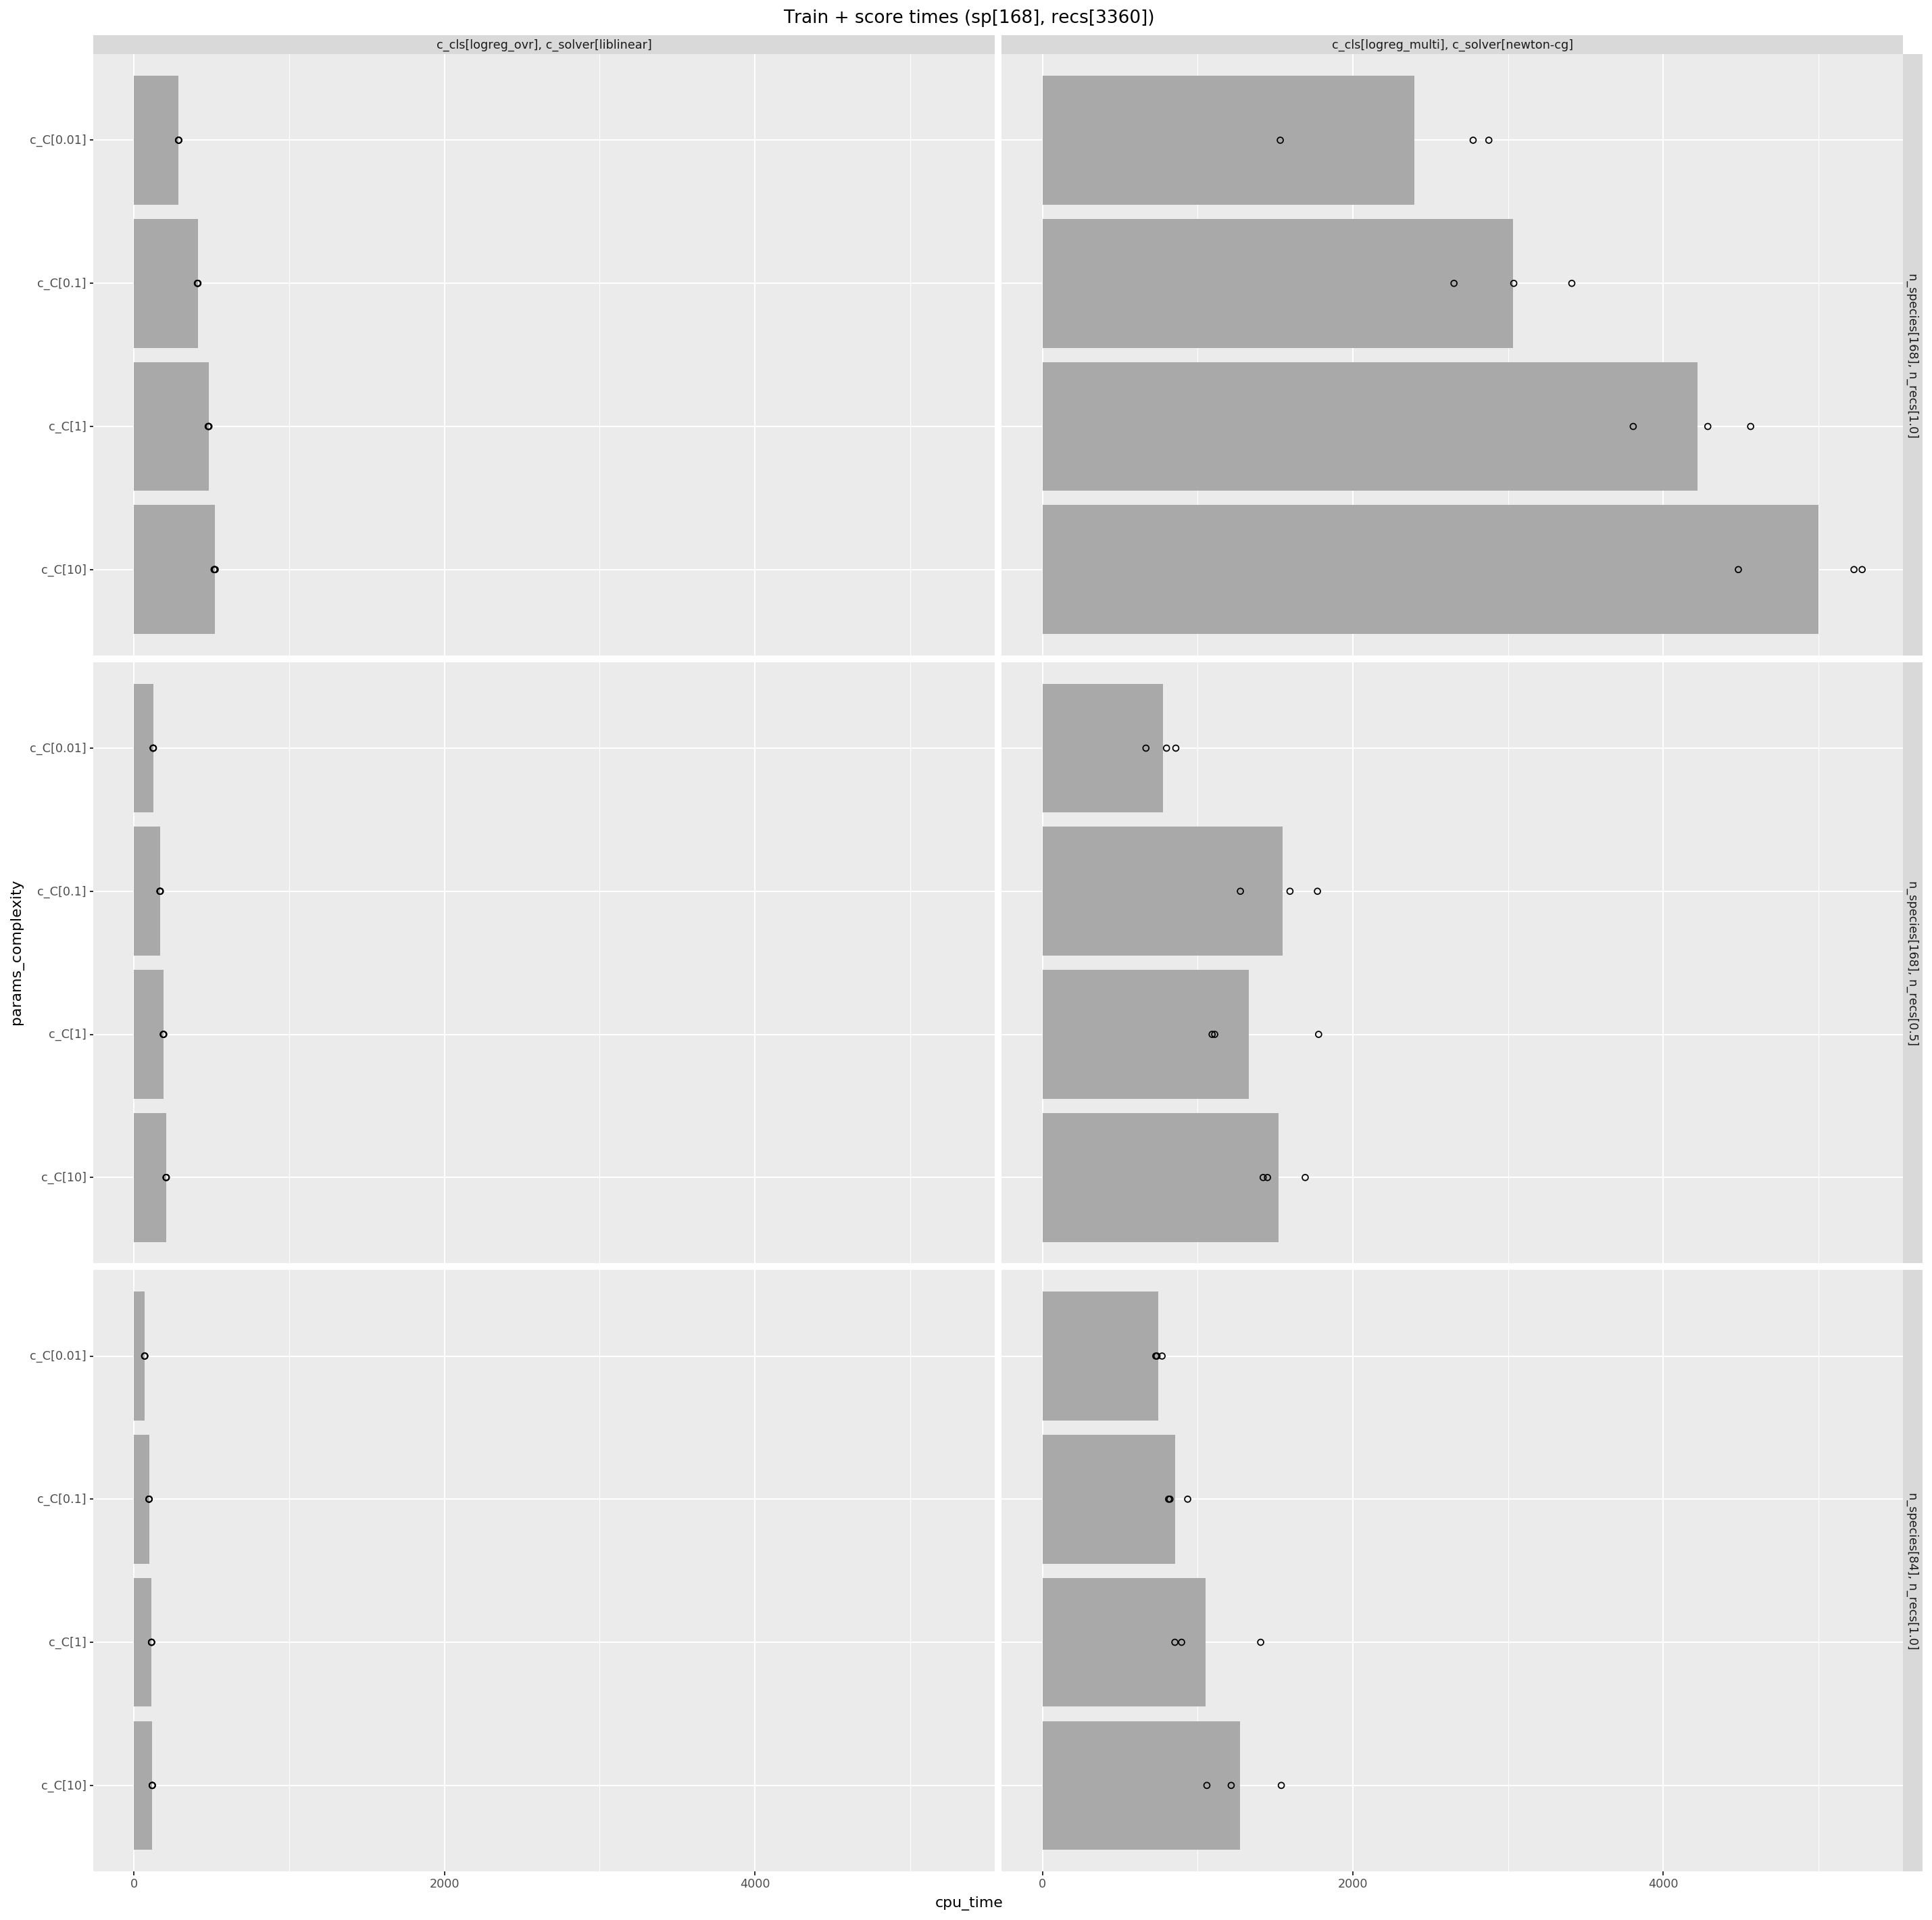

<ggplot: (-9223363270143188515)>

In [ ]:
# TODO TODO Why are xgb train/score times bimodal?
#   - [x] Plot test_score ~ cpu_time -- anything informative here? [left panel!]
#   - [ ] Maybe the bimodal tree depths cause bimodal train/score times? -- plot the relationship
#       - But that'd be weird, since a gbm forest should avg out the individual tree depths...
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_total_mean=lambda df: df.cpu_time.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_col(aes(y='cpu_total_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time'), color='black', fill='none', size=2)
    + coord_flip()
    + ylab('cpu_time')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Train + score times ({recs_stats})')
)

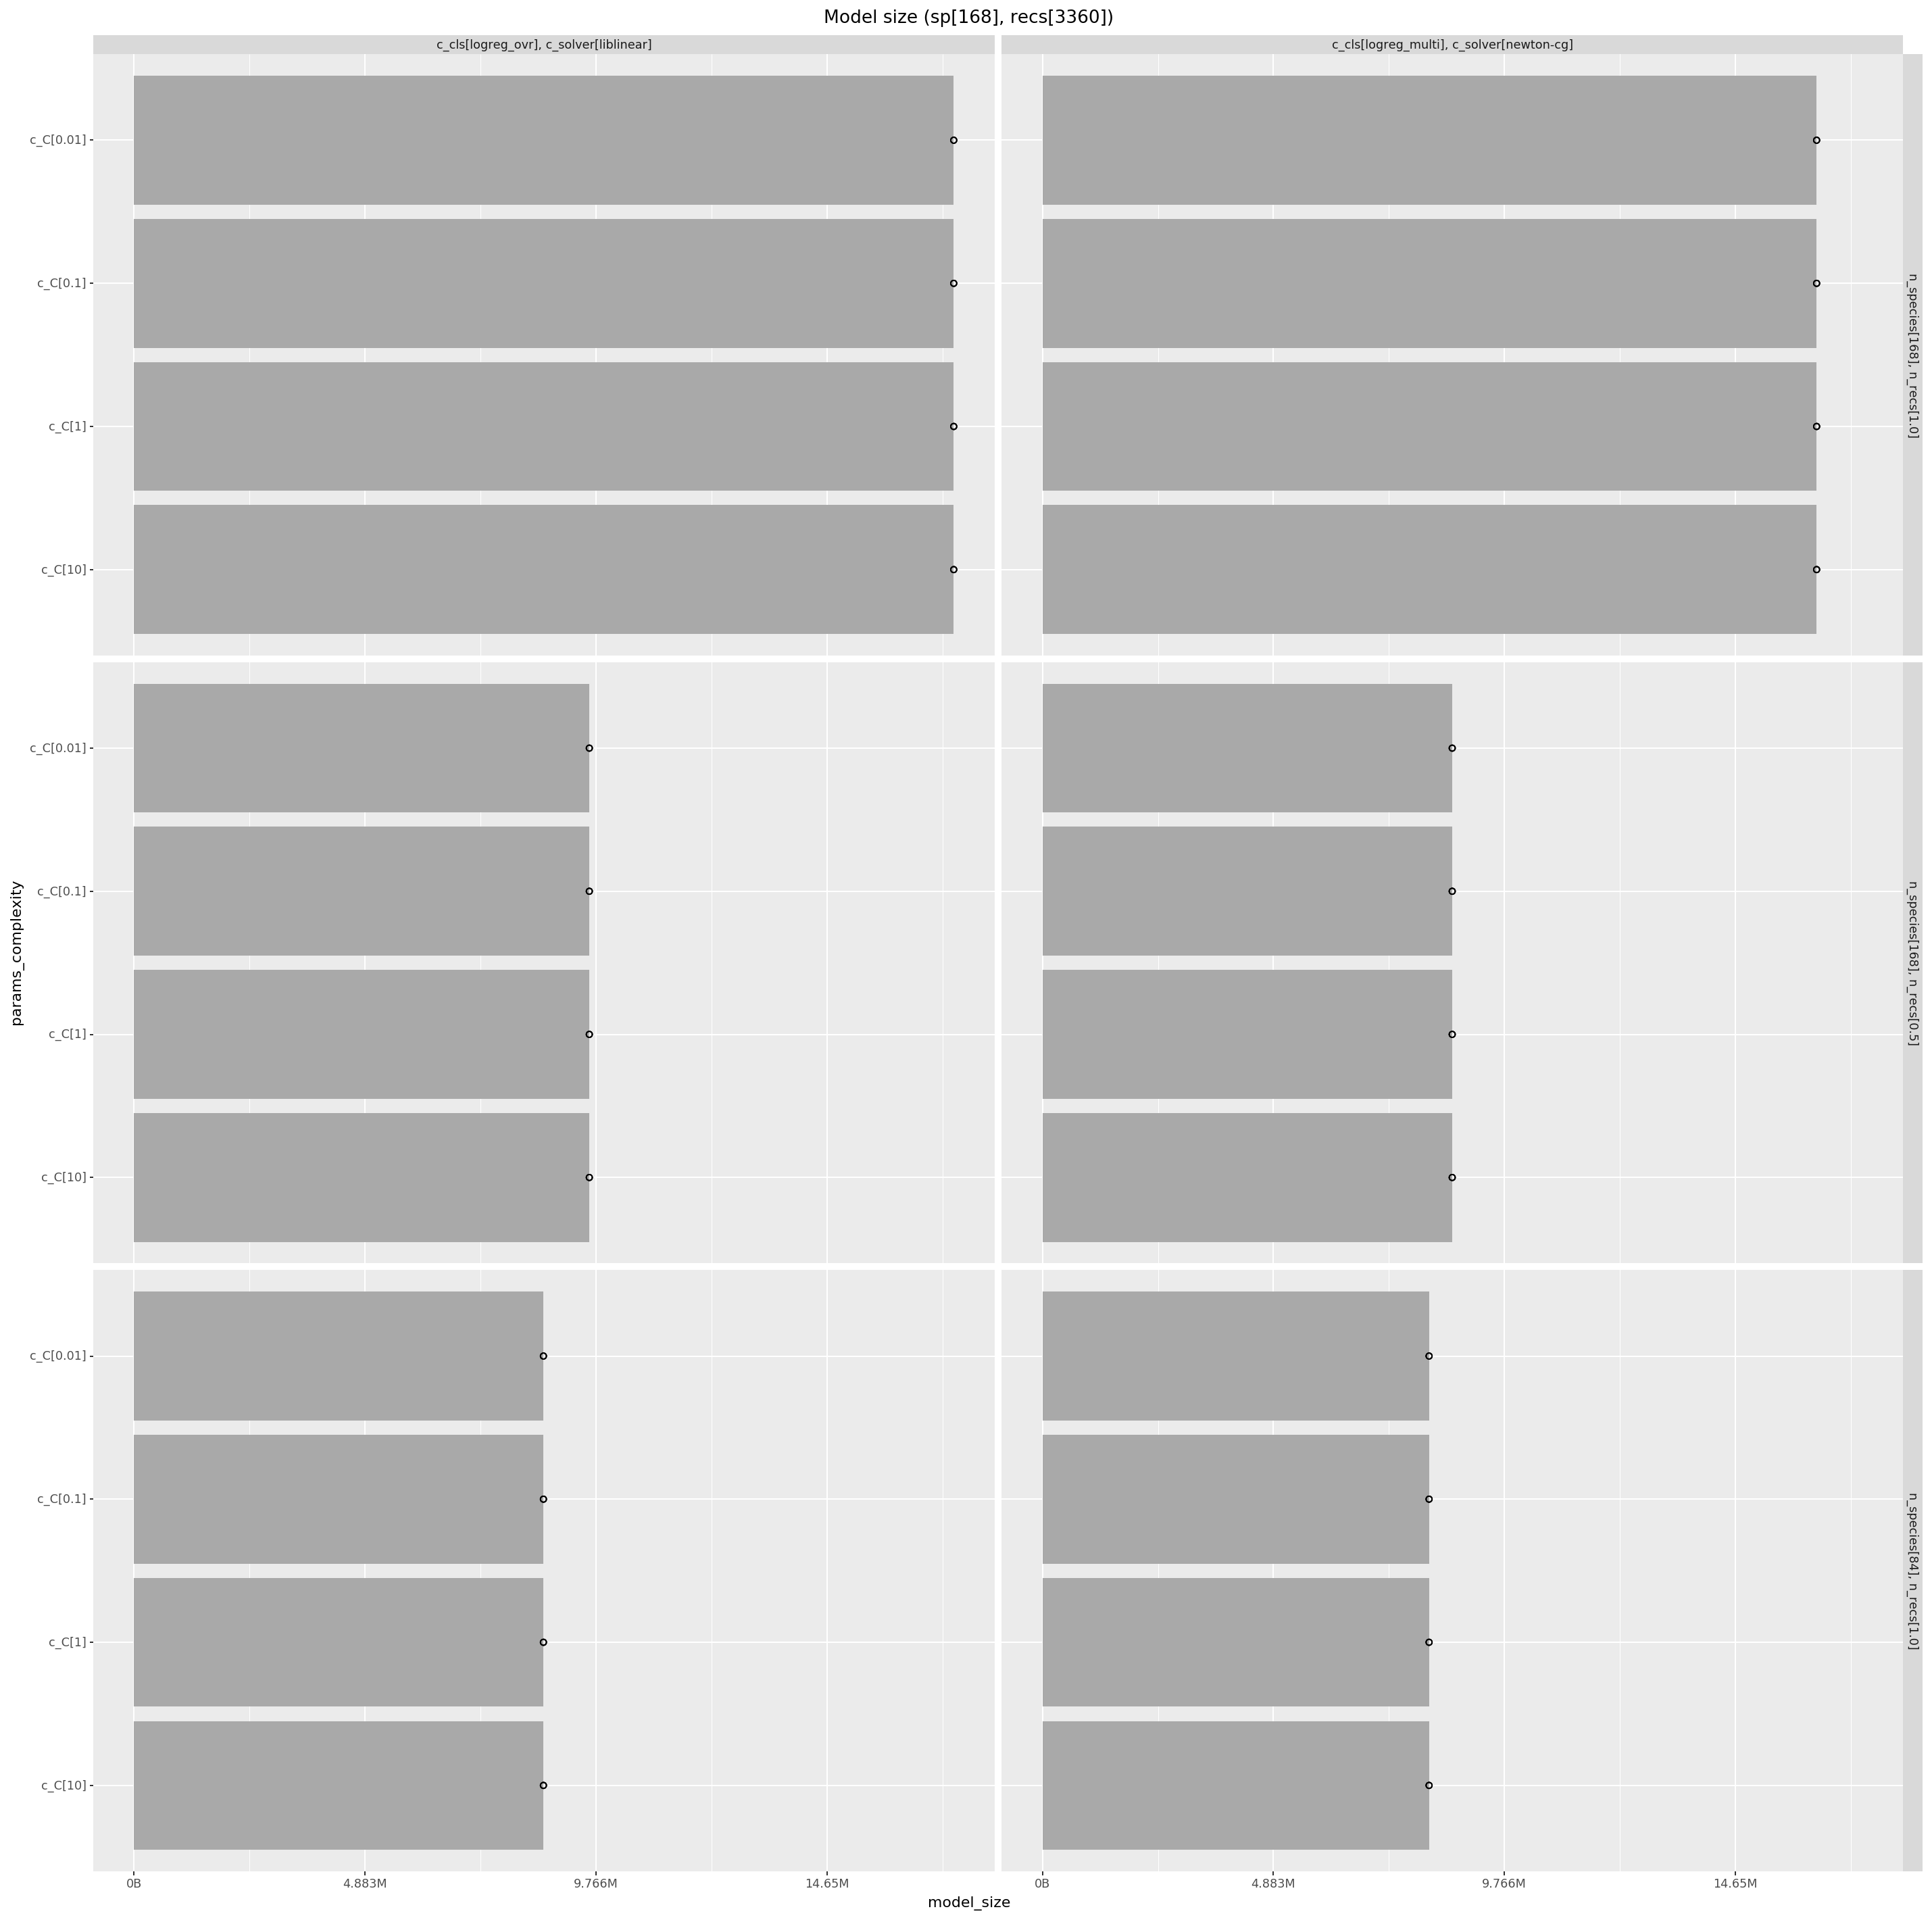

<ggplot: (-9223363270128816815)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

In [ ]:
# Forest depth stats so we can tune max_depth, model_size
#   - TODO Generalize for models other than tree ensembles
cv_models = (cv_models
    .assign(
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
)
display(
    # cv_models[['model_id', 'forest_depth_mean', 'forest_depth_std']][:5],
)

In [ ]:
# TODO TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([[] if x is None else x.depth for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
    + coord_flip()
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')

)

[skip]

In [ ]:
# XXX Revive if insightful
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)

[skip]

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_delta_mean=lambda df: df.mem_rss_delta.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_delta_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_delta'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

[skip]

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

[skip]

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

[skip]

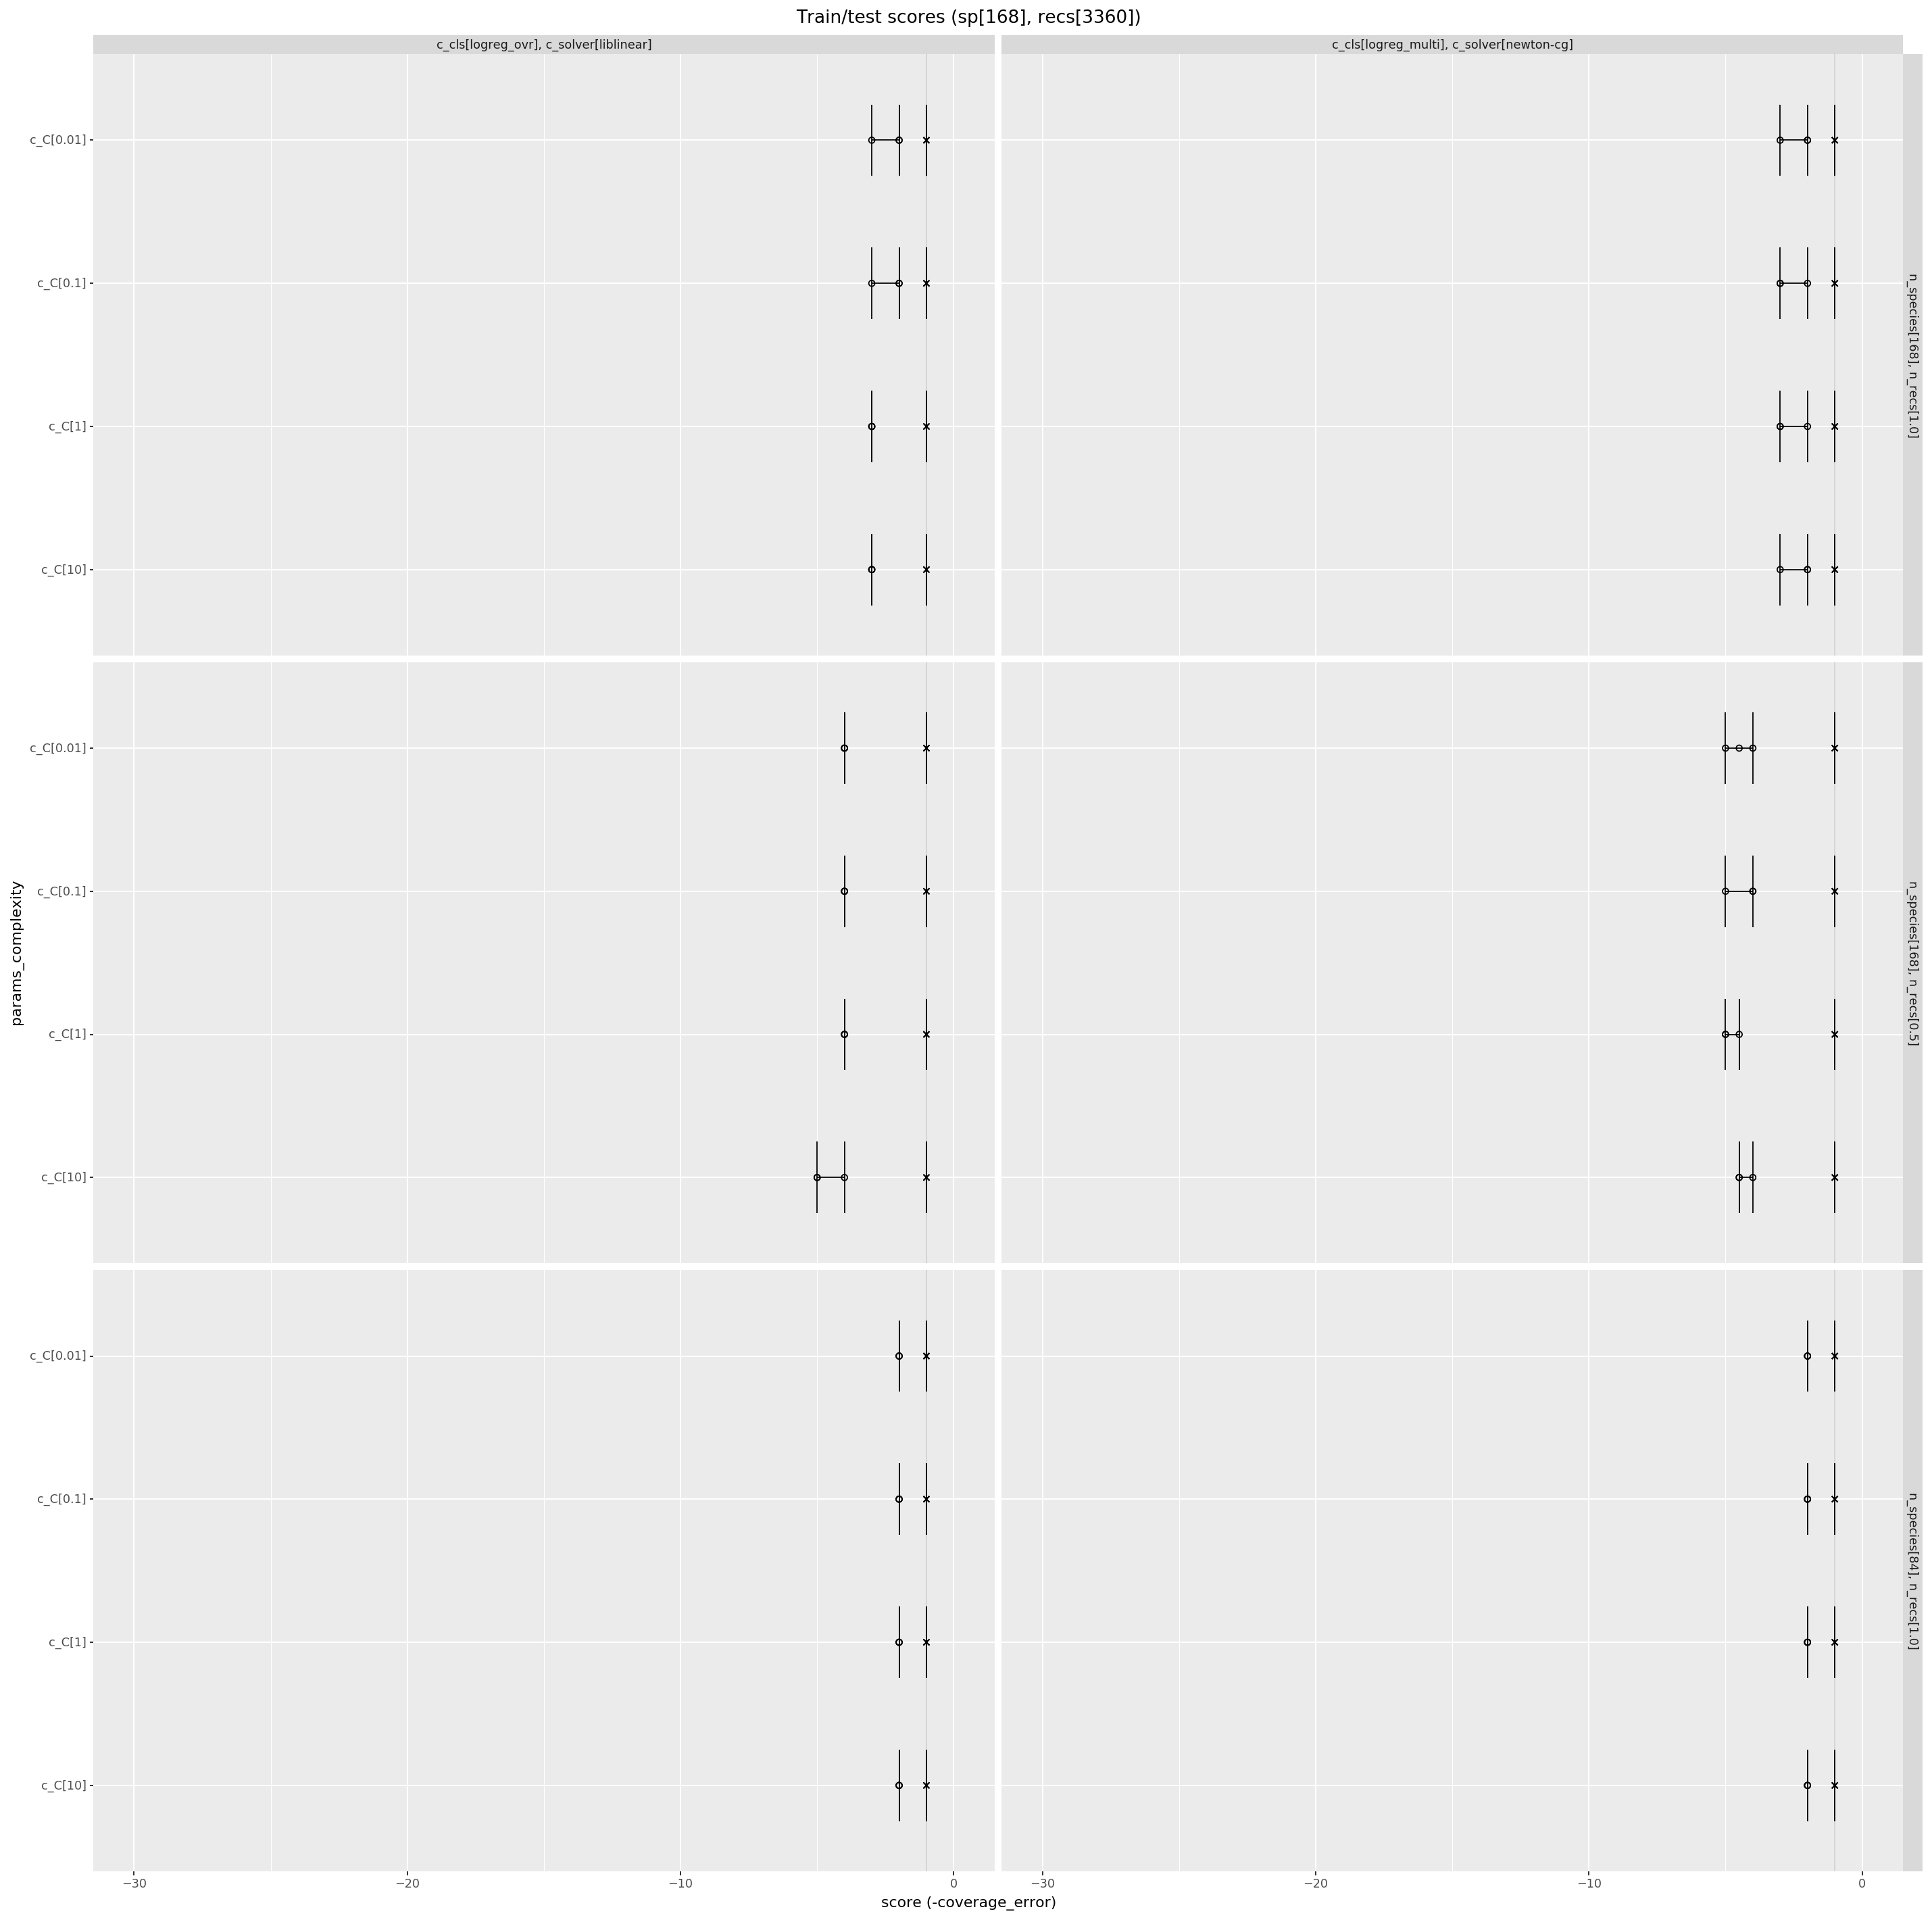

<ggplot: (-9223363270136055541)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=['params_data', 'params_model', 'params_complexity', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.params_complexity.str.cat(df.split, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(lambda df: (df
        .pipe(ggplot)
        + aes(x='params_complexity')
        + aes(y='score')
        + facet_grid('params_data ~ params_model')
        + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
        + geom_point(data=df[df.split == 'test'], shape='o', fill='none', size=2)
        + geom_point(data=df[df.split == 'train'], shape='x', size=2)
        + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
        + coord_flip(
            ylim=(-30, 0),
        )
        + scale_shape_manual(values=['o', 'x'], guide=False)
        + theme_figsize(width=24, aspect_ratio=1/1.5)
        + ylab('score (-coverage_error)')
        + ggtitle(f'Train/test scores ({recs_stats})')
    ))
)

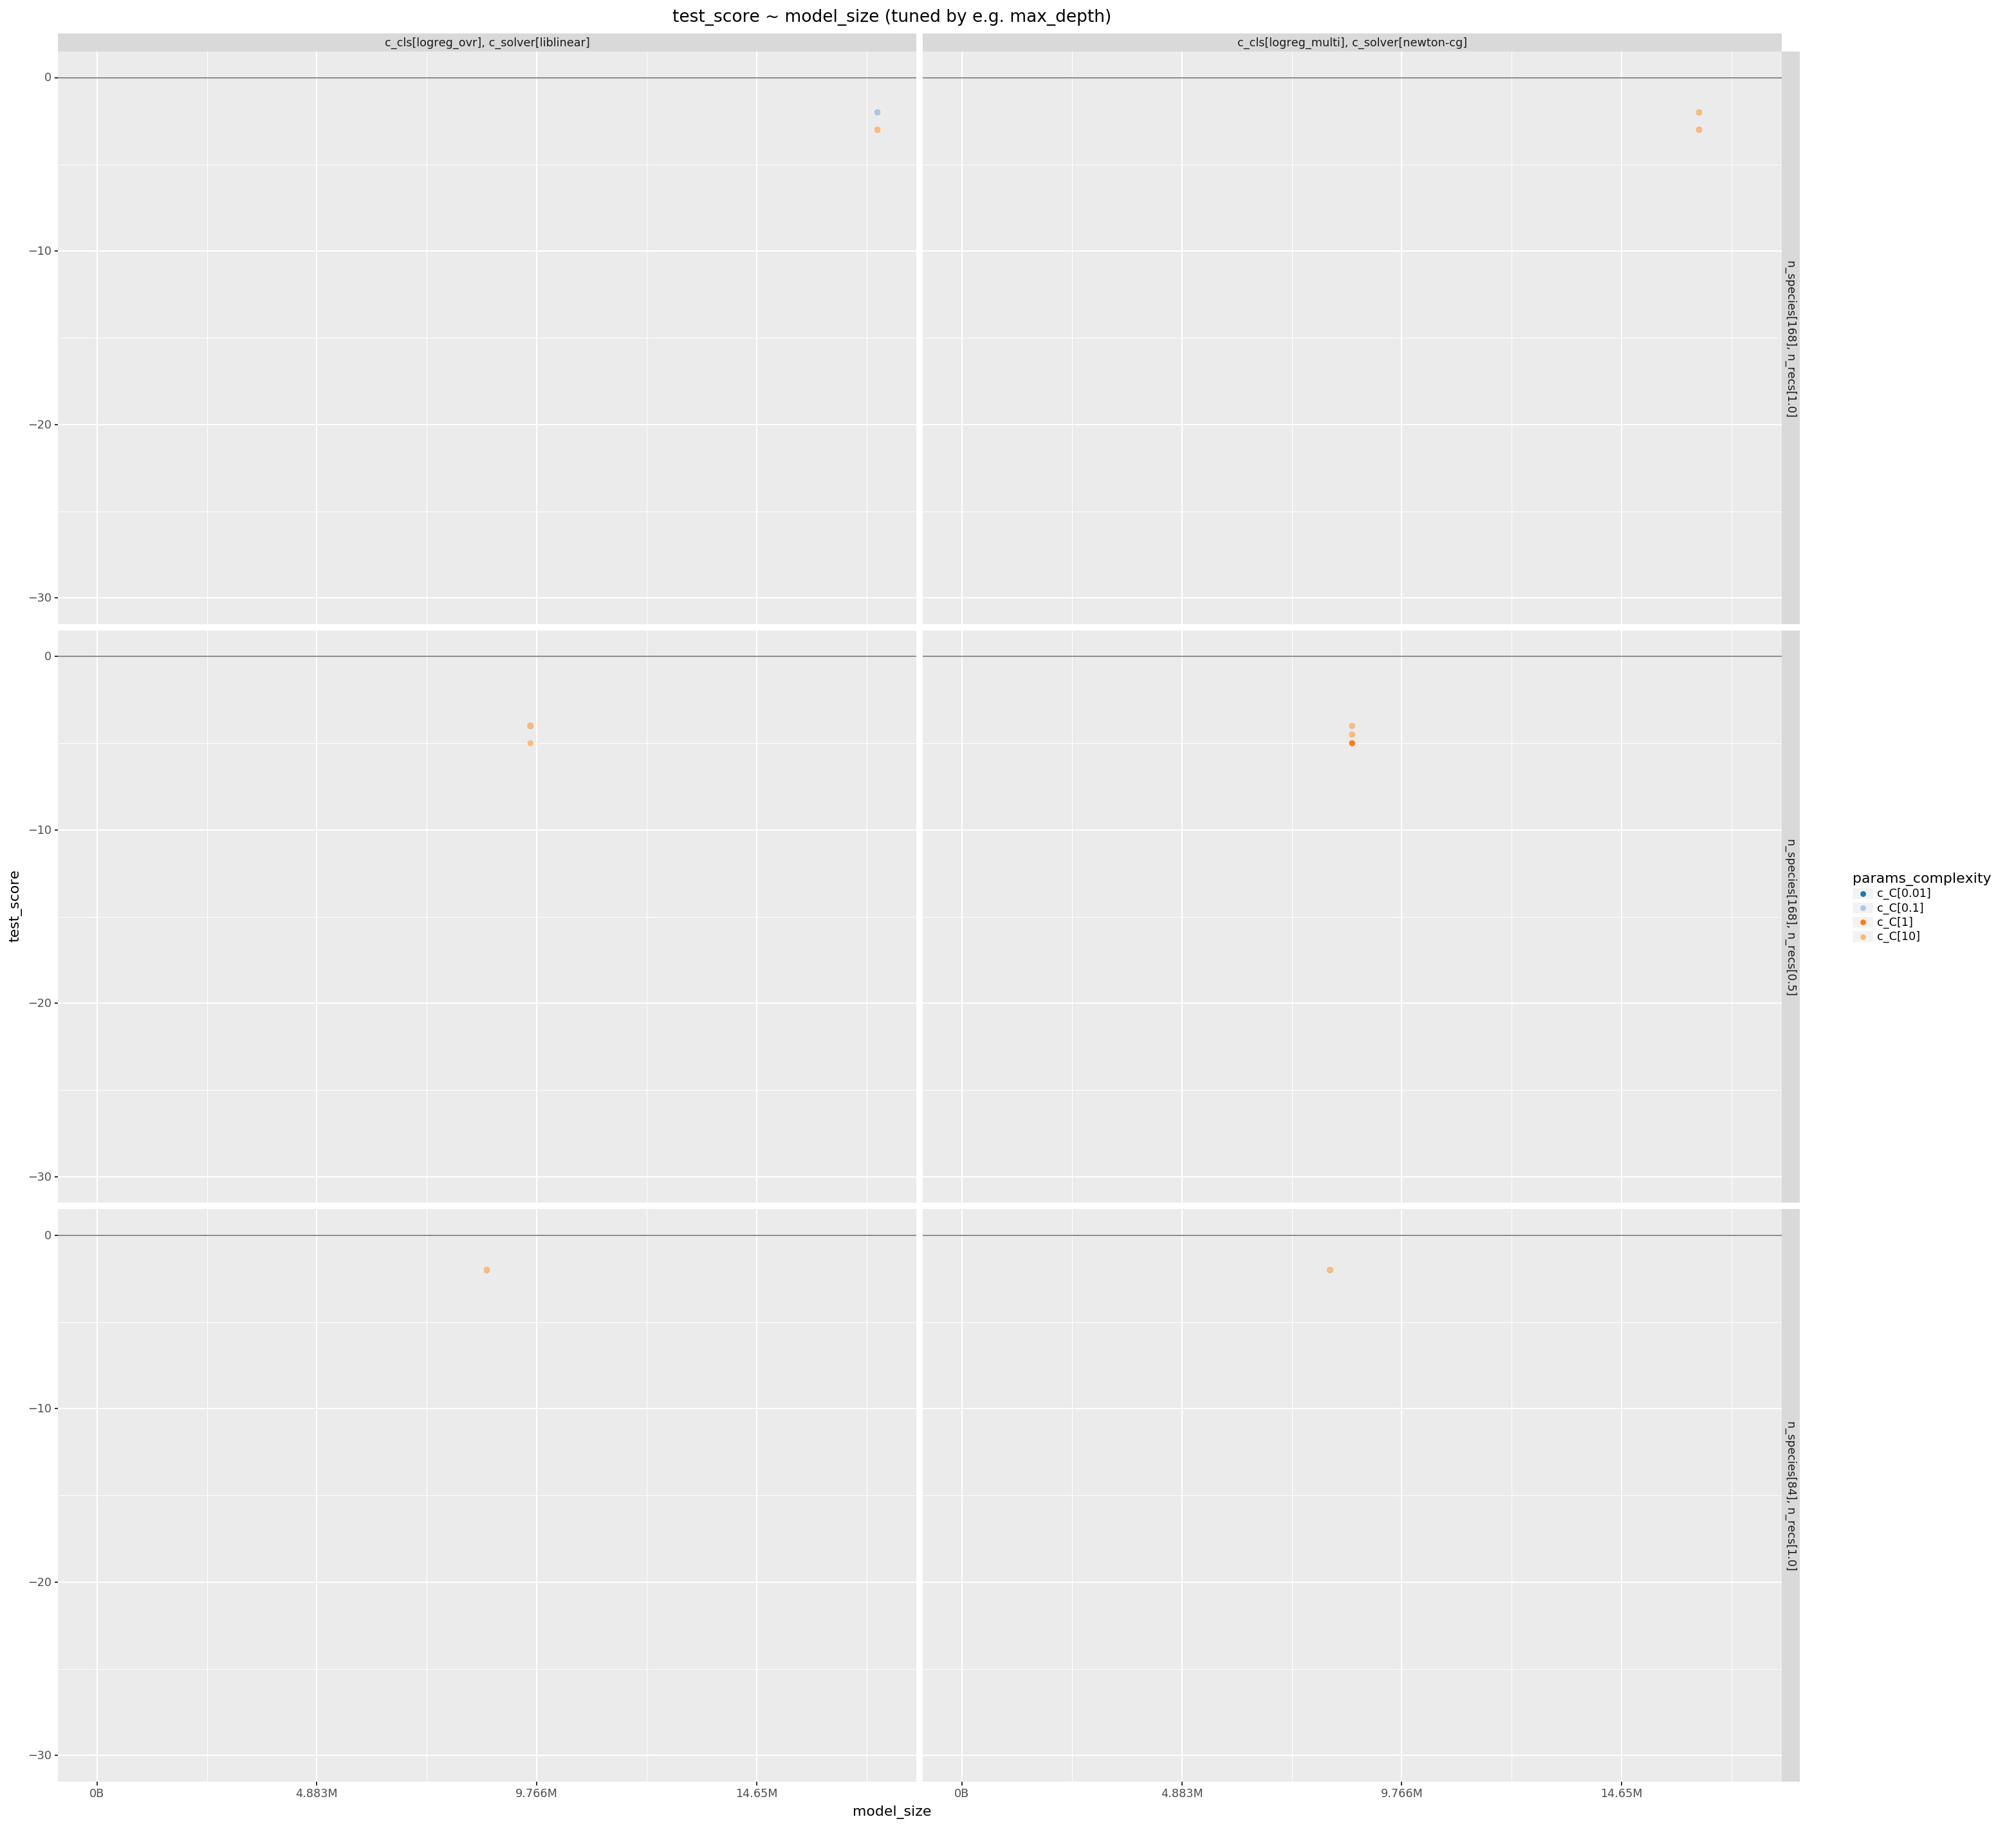

<ggplot: (8766725901590)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size', y='test_score')
    + aes(color='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ model_size (tuned by e.g. max_depth)')
)

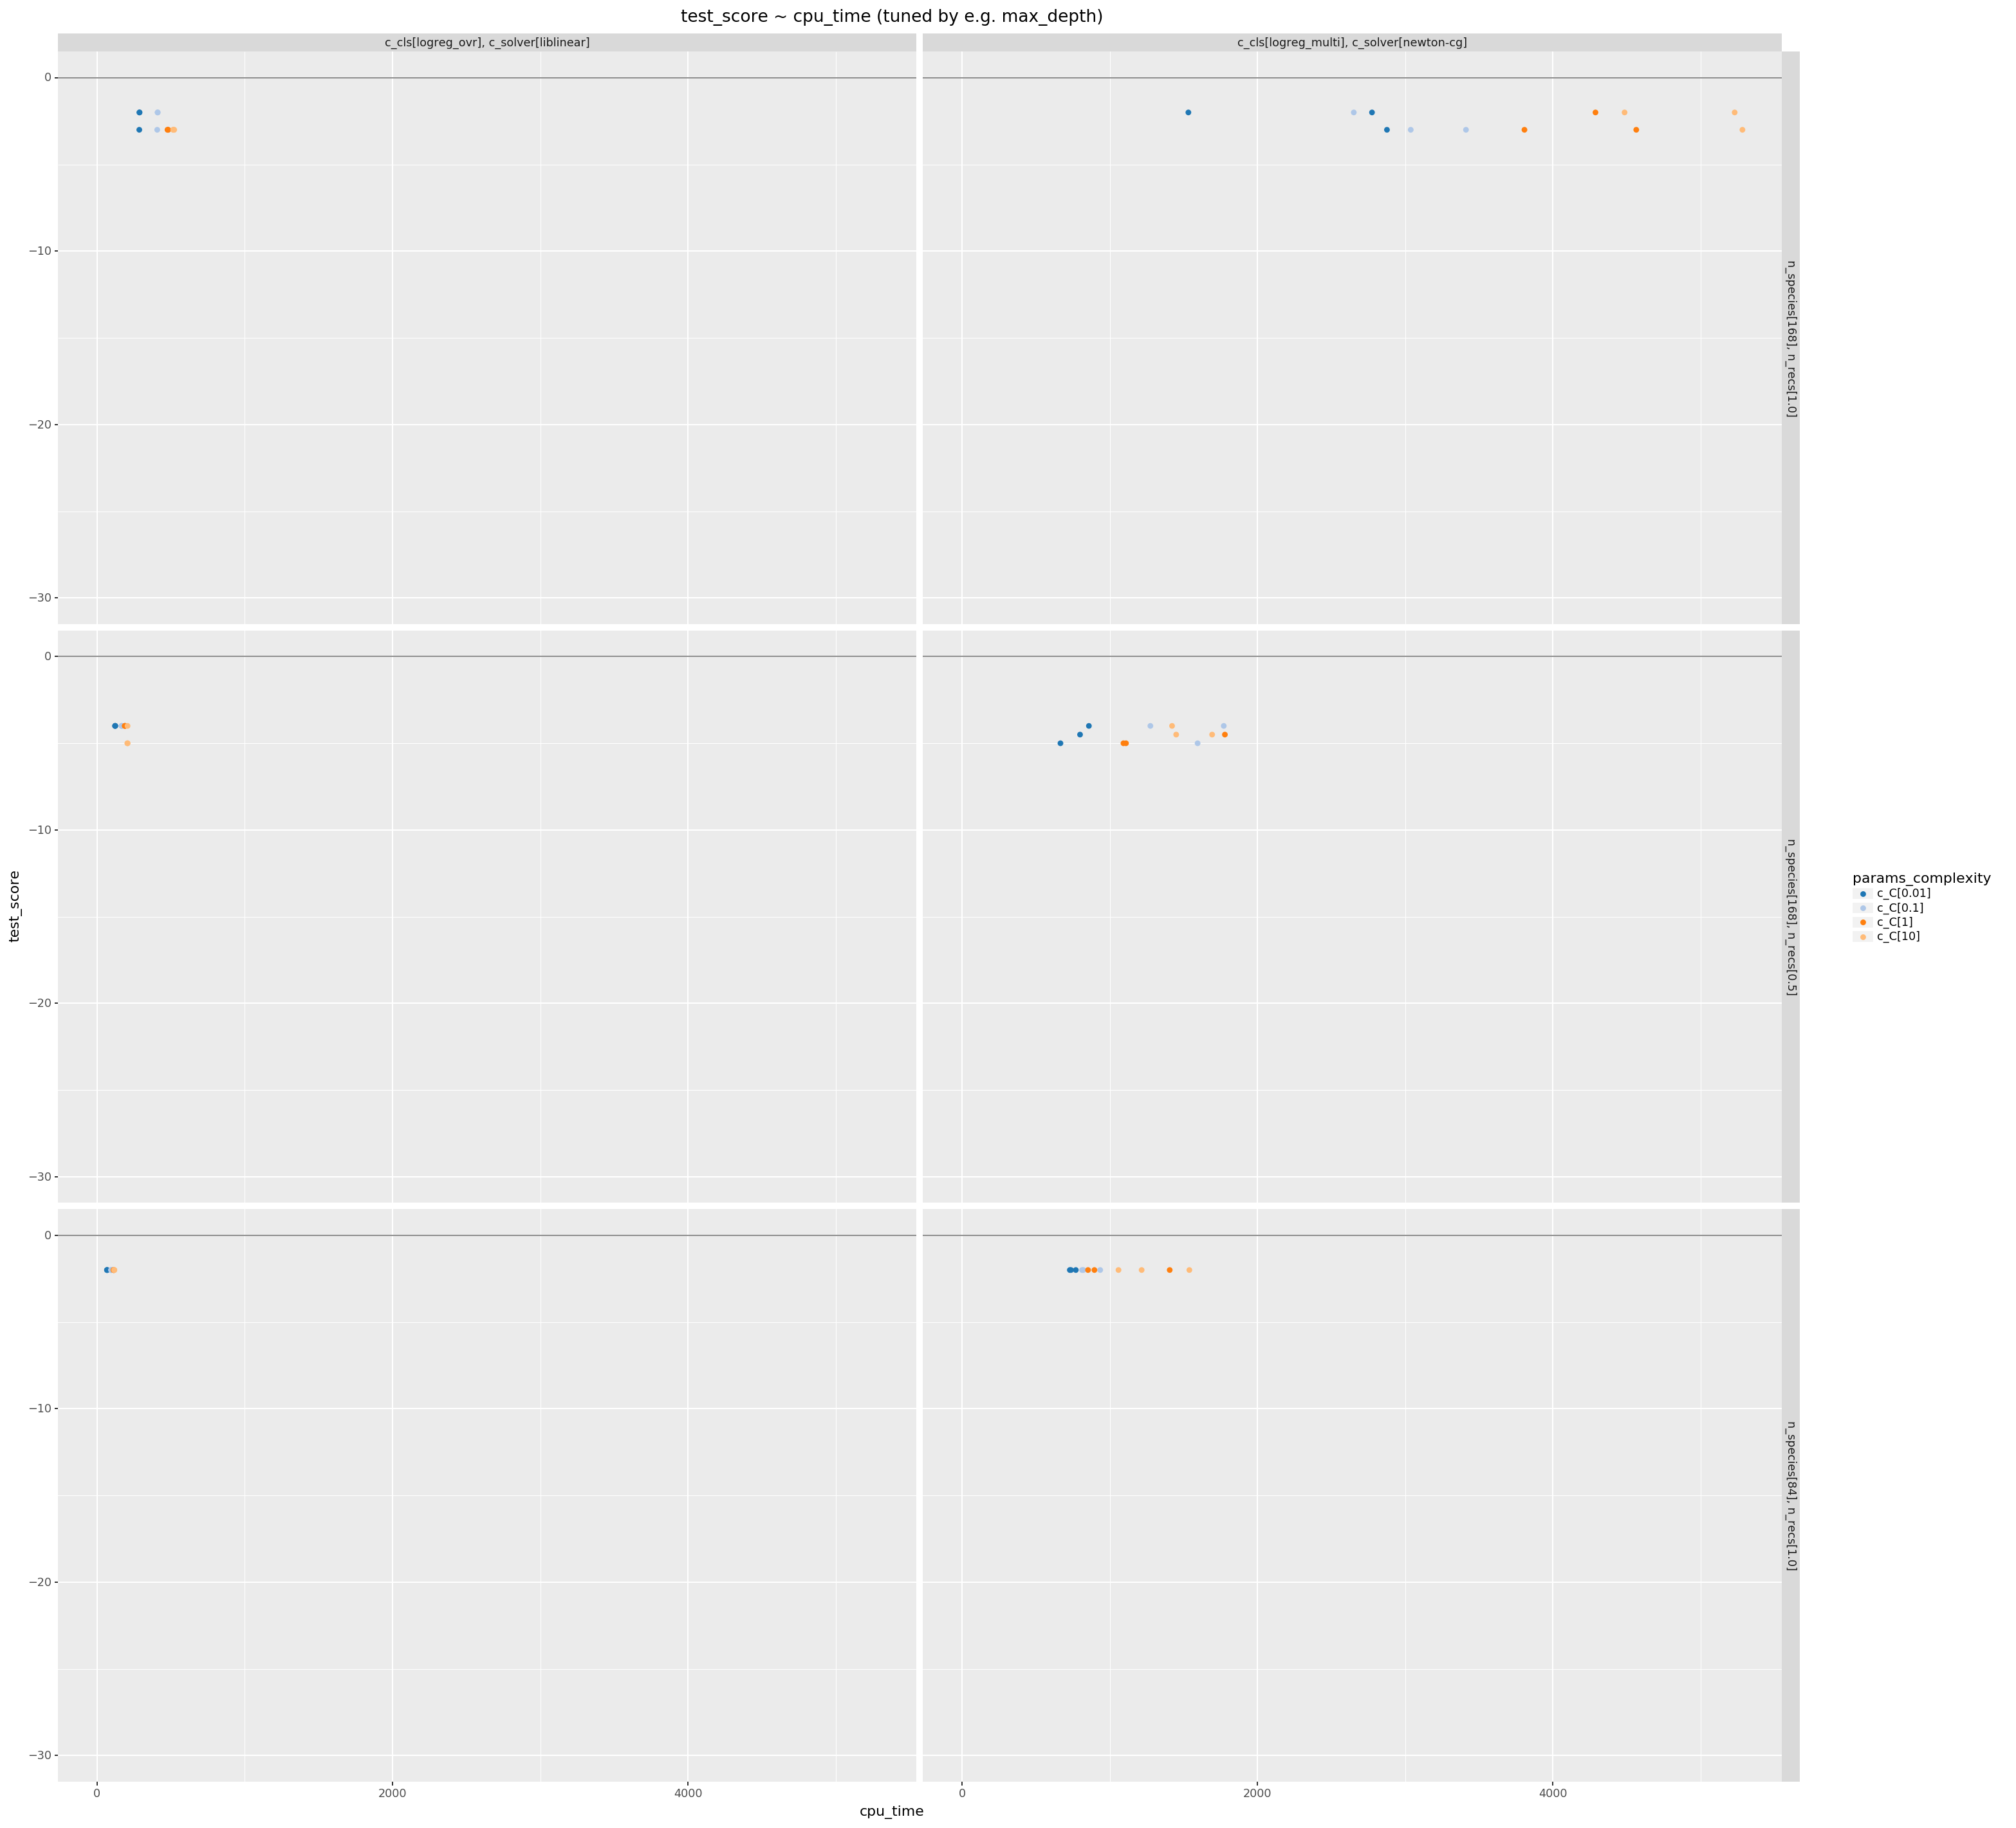

<ggplot: (-9223363270143242082)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time', y='test_score')
    + aes(color='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    # + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ cpu_time (tuned by e.g. max_depth)')
)

In [ ]:
# SLOW_PLOTS_NEXT

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/24]
  fold[*/3]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_data=row.params_data,
            params_model=row.params_model,
            params_complexity=row.params_complexity,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_data=cv_models.params_data.dtype,
        params_model=cv_models.params_model.dtype,
        params_complexity=cv_models.params_complexity.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

  0%|                                                                                                        | 0/72 [00:00<?, ?it/s]

  3%|██▋                                                                                             | 2/72 [00:00<00:04, 15.65it/s]

  6%|█████▎                                                                                          | 4/72 [00:00<00:04, 15.70it/s]

  8%|████████                                                                                        | 6/72 [00:00<00:04, 15.54it/s]

 11%|██████████▋                                                                                     | 8/72 [00:00<00:04, 15.54it/s]

 14%|█████████████▏                                                                                 | 10/72 [00:00<00:03, 15.57it/s]

 17%|███████████████▊                                                                               | 12/72 [00:00<00:03, 15.48it/s]

 19%|██████████████████▍                                                                            | 14/72 [00:00<00:03, 15.45it/s]

 22%|█████████████████████                                                                          | 16/72 [00:01<00:03, 15.45it/s]

 25%|███████████████████████▊                                                                       | 18/72 [00:01<00:03, 15.47it/s]

 28%|██████████████████████████▍                                                                    | 20/72 [00:01<00:03, 15.49it/s]

 31%|█████████████████████████████                                                                  | 22/72 [00:01<00:03, 15.47it/s]

 33%|███████████████████████████████▋                                                               | 24/72 [00:01<00:03, 15.47it/s]

 36%|██████████████████████████████████▎                                                            | 26/72 [00:01<00:02, 15.47it/s]

 39%|████████████████████████████████████▉                                                          | 28/72 [00:01<00:02, 15.48it/s]

 42%|███████████████████████████████████████▌                                                       | 30/72 [00:01<00:02, 15.50it/s]

 44%|██████████████████████████████████████████▏                                                    | 32/72 [00:02<00:02, 15.52it/s]

 47%|████████████████████████████████████████████▊                                                  | 34/72 [00:02<00:02, 15.53it/s]

 50%|███████████████████████████████████████████████▌                                               | 36/72 [00:02<00:02, 15.50it/s]

 53%|██████████████████████████████████████████████████▏                                            | 38/72 [00:02<00:02, 15.51it/s]

 56%|████████████████████████████████████████████████████▊                                          | 40/72 [00:02<00:02, 15.51it/s]

 58%|███████████████████████████████████████████████████████▍                                       | 42/72 [00:02<00:01, 15.49it/s]

 61%|██████████████████████████████████████████████████████████                                     | 44/72 [00:02<00:01, 15.49it/s]

 64%|████████████████████████████████████████████████████████████▋                                  | 46/72 [00:02<00:01, 15.48it/s]

 67%|███████████████████████████████████████████████████████████████▎                               | 48/72 [00:03<00:01, 15.47it/s]

 72%|████████████████████████████████████████████████████████████████████▌                          | 52/72 [00:03<00:01, 16.10it/s]

 78%|█████████████████████████████████████████████████████████████████████████▉                     | 56/72 [00:03<00:00, 16.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▏               | 60/72 [00:03<00:00, 17.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▍          | 64/72 [00:03<00:00, 17.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 68/72 [00:03<00:00, 18.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 18.57it/s]

min  \
                  dtype    sizeof  len   count nunique mean     std                                                                                                
model_id          category 5455296 40320 40320 72      NaN      NaN      n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
params            category 5092416 40320 40320 24      NaN      NaN               n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]   
params_data       category 3056256 40320 40320 3       NaN      NaN                                                                  n_species[168], n_recs[1.0]   
params_model      category 3548160 40320 40320 2       NaN      NaN                                                       c_cls[logreg_ovr], c_solver[liblinear]   
params_complexity category 2278080 40320 40320 4       NaN      NaN                                                                                    c_C[0.01]   
fold              int64    1075200 40320 40320 3       1.000    0.817                                                                                          0   
i                 int64    1128960 40320 40320 1642    1687.027 967.390                                                                                        1   
y_true            object   3427200 40320 40320 168     NaN      NaN                                                                                         ACWO   
coverage_error    float64  967680  40320 40320 168     14.115   25.769                                                                                         1   

                                                                                                                                                          25%  \
                  dtype    sizeof  len   count nunique mean     std                                                                                             
model_id          category 5455296 40320 40320 72      NaN      NaN      n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[1], fold[2]   
params            category 5092416 40320 40320 24      NaN      NaN               n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[1]   
params_data       category 3056256 40320 40320 3       NaN      NaN                                                               n_species[168], n_recs[1.0]   
params_model      category 3548160 40320 40320 2       NaN      NaN                                                    c_cls[logreg_ovr], c_solver[liblinear]   
params_complexity category 2278080 40320 40320 4       NaN      NaN                                                                                 c_C[0.01]   
fold              int64    1075200 40320 40320 3       1.000    0.817                                                                                       0   
i                 int64    1128960 40320 40320 1642    1687.027 967.390                                                                                   851   
y_true            object   3427200 40320 40320 168     NaN      NaN                                                                                      CORA   
coverage_error    float64  967680  40320 40320 168     14.115   25.769                                                                                      1   

                                                                                                                                                               50%  \
                  dtype    sizeof  len   count nunique mean     std                                                                                                  
model_id          category 5455296 40320 40320 72      NaN      NaN      n_species[168], n_recs[0.5], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.01], fold[2]   
params            category 5092416 40320 40320 24      NaN      NaN               

model_id  \
0  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
1  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
2  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
3  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
4  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   

                                                                           params                  params_data  \
0  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
1  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
2  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
3  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
4  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   

                             params_model params_complexity  fold     i y_true  coverage_error  
0  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  1335   HAWO             1.0  
1  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  1219   BTAH             3.0  
2  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  1159   MWPW             1.0  
3  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  3033   WETA             1.0  
4  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0   635   LBDO            26.0

In [ ]:
params_data = 'n_species[168], n_recs[1.0]'
n_species = parse.search('n_species[{n_species:d}], n_recs[{n_recs:f}]', params_data)['n_species']

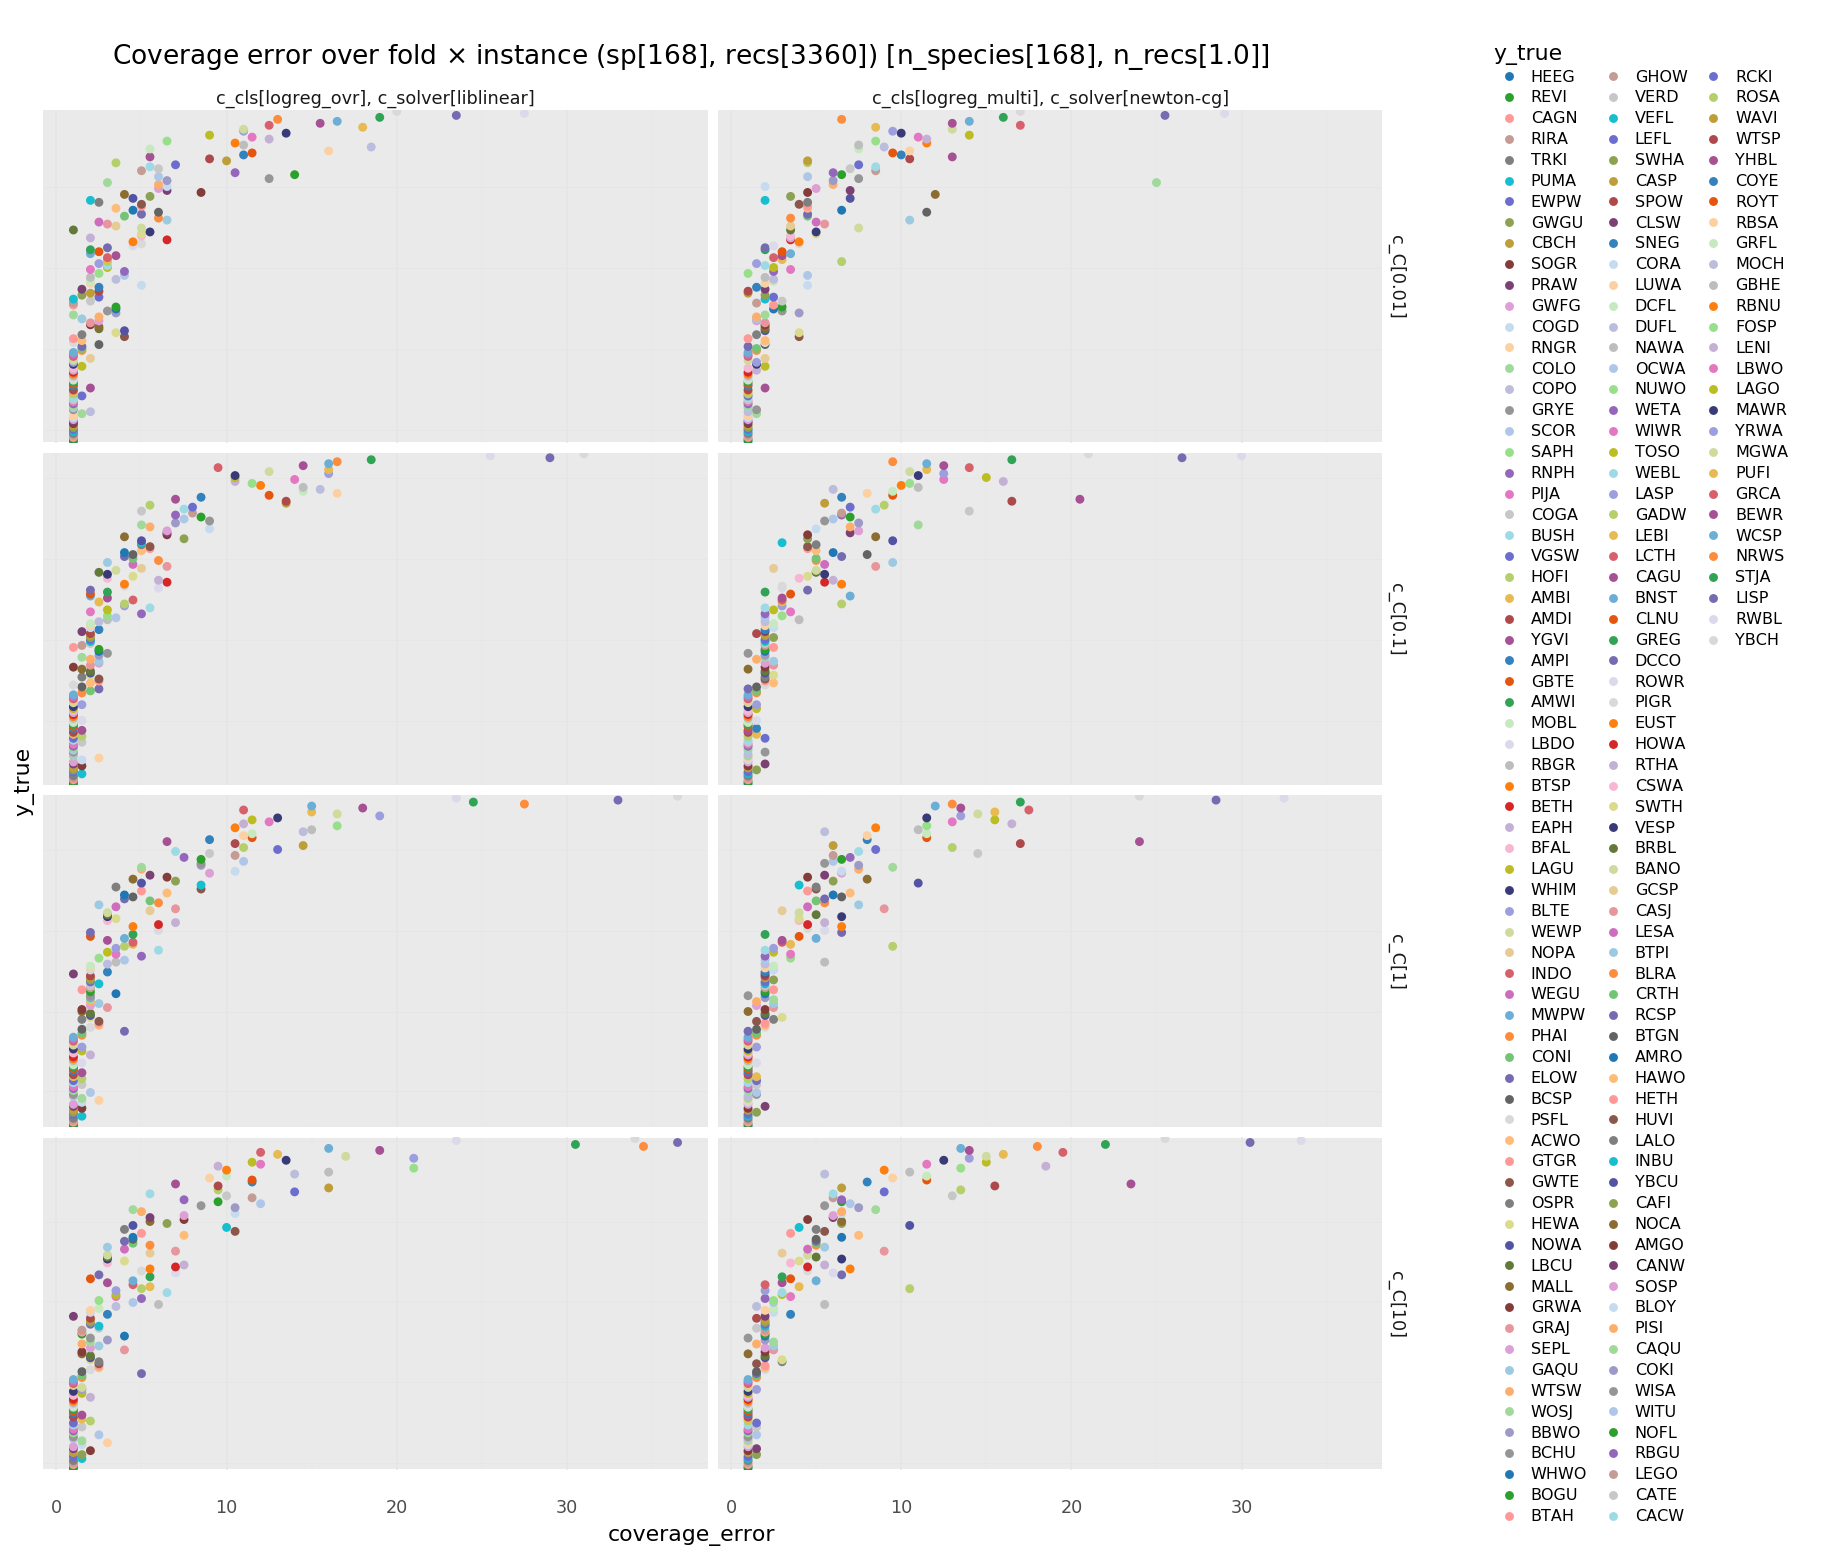

<ggplot: (-9223363270143249846)>

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot)
    + aes(x='y_true', y='coverage_error')
    + aes(color='y_true')
    + facet_grid('params_complexity ~ params_model')
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + theme_minimal()  # Before other theme()
    + guides(color=guide_legend(nrow=70))
    + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8, legend_text=element_text(size=8))
    + theme(axis_text_y=element_blank())
    + theme_figsize(width=12, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance ({recs_stats}) [{params_data}]')
)

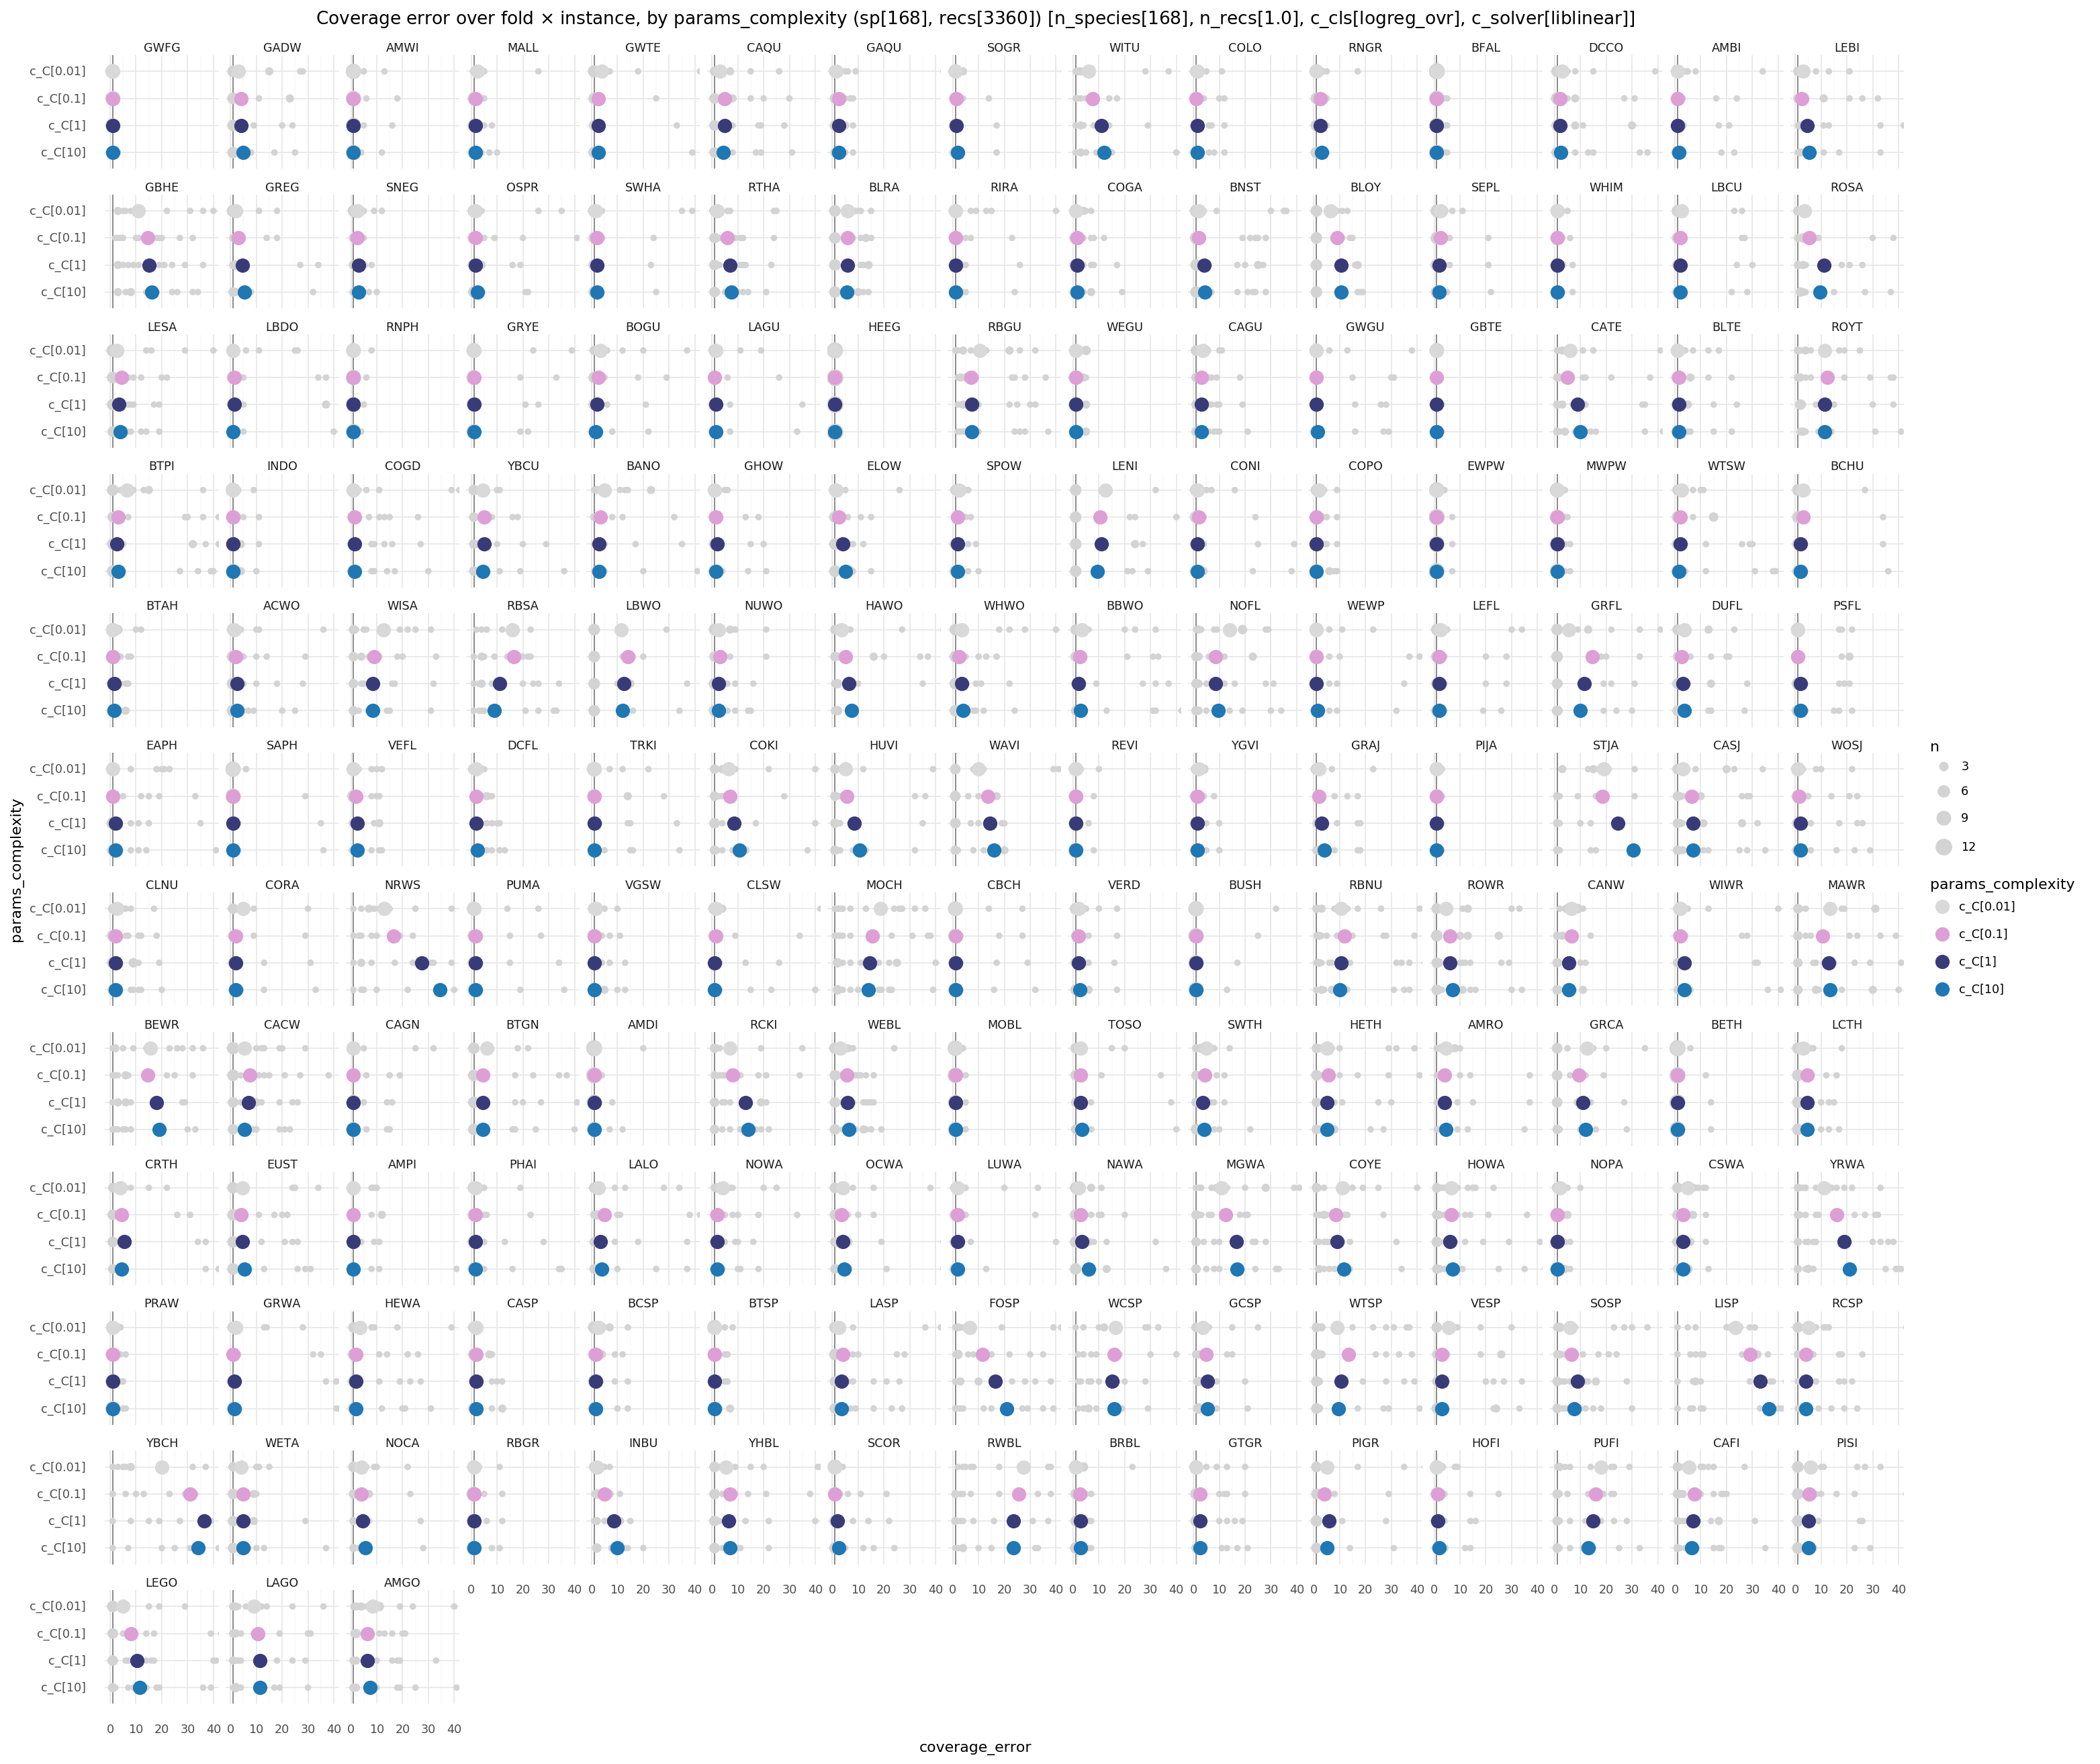

<ggplot: (-9223363269868580299)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
# params_model = 'c_cls[rf], c_n_estimators[100]'
# params_model = 'c_cls[logreg_multi], c_solver[newton-cg]'
params_model = 'c_cls[logreg_ovr], c_solver[liblinear]'
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_model == params_model]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity', y='coverage_error')
    + aes(color='params_complexity')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    # + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab10'))  # Strong
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=24, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_complexity ({recs_stats}) [{params_data}, {params_model}]')
)

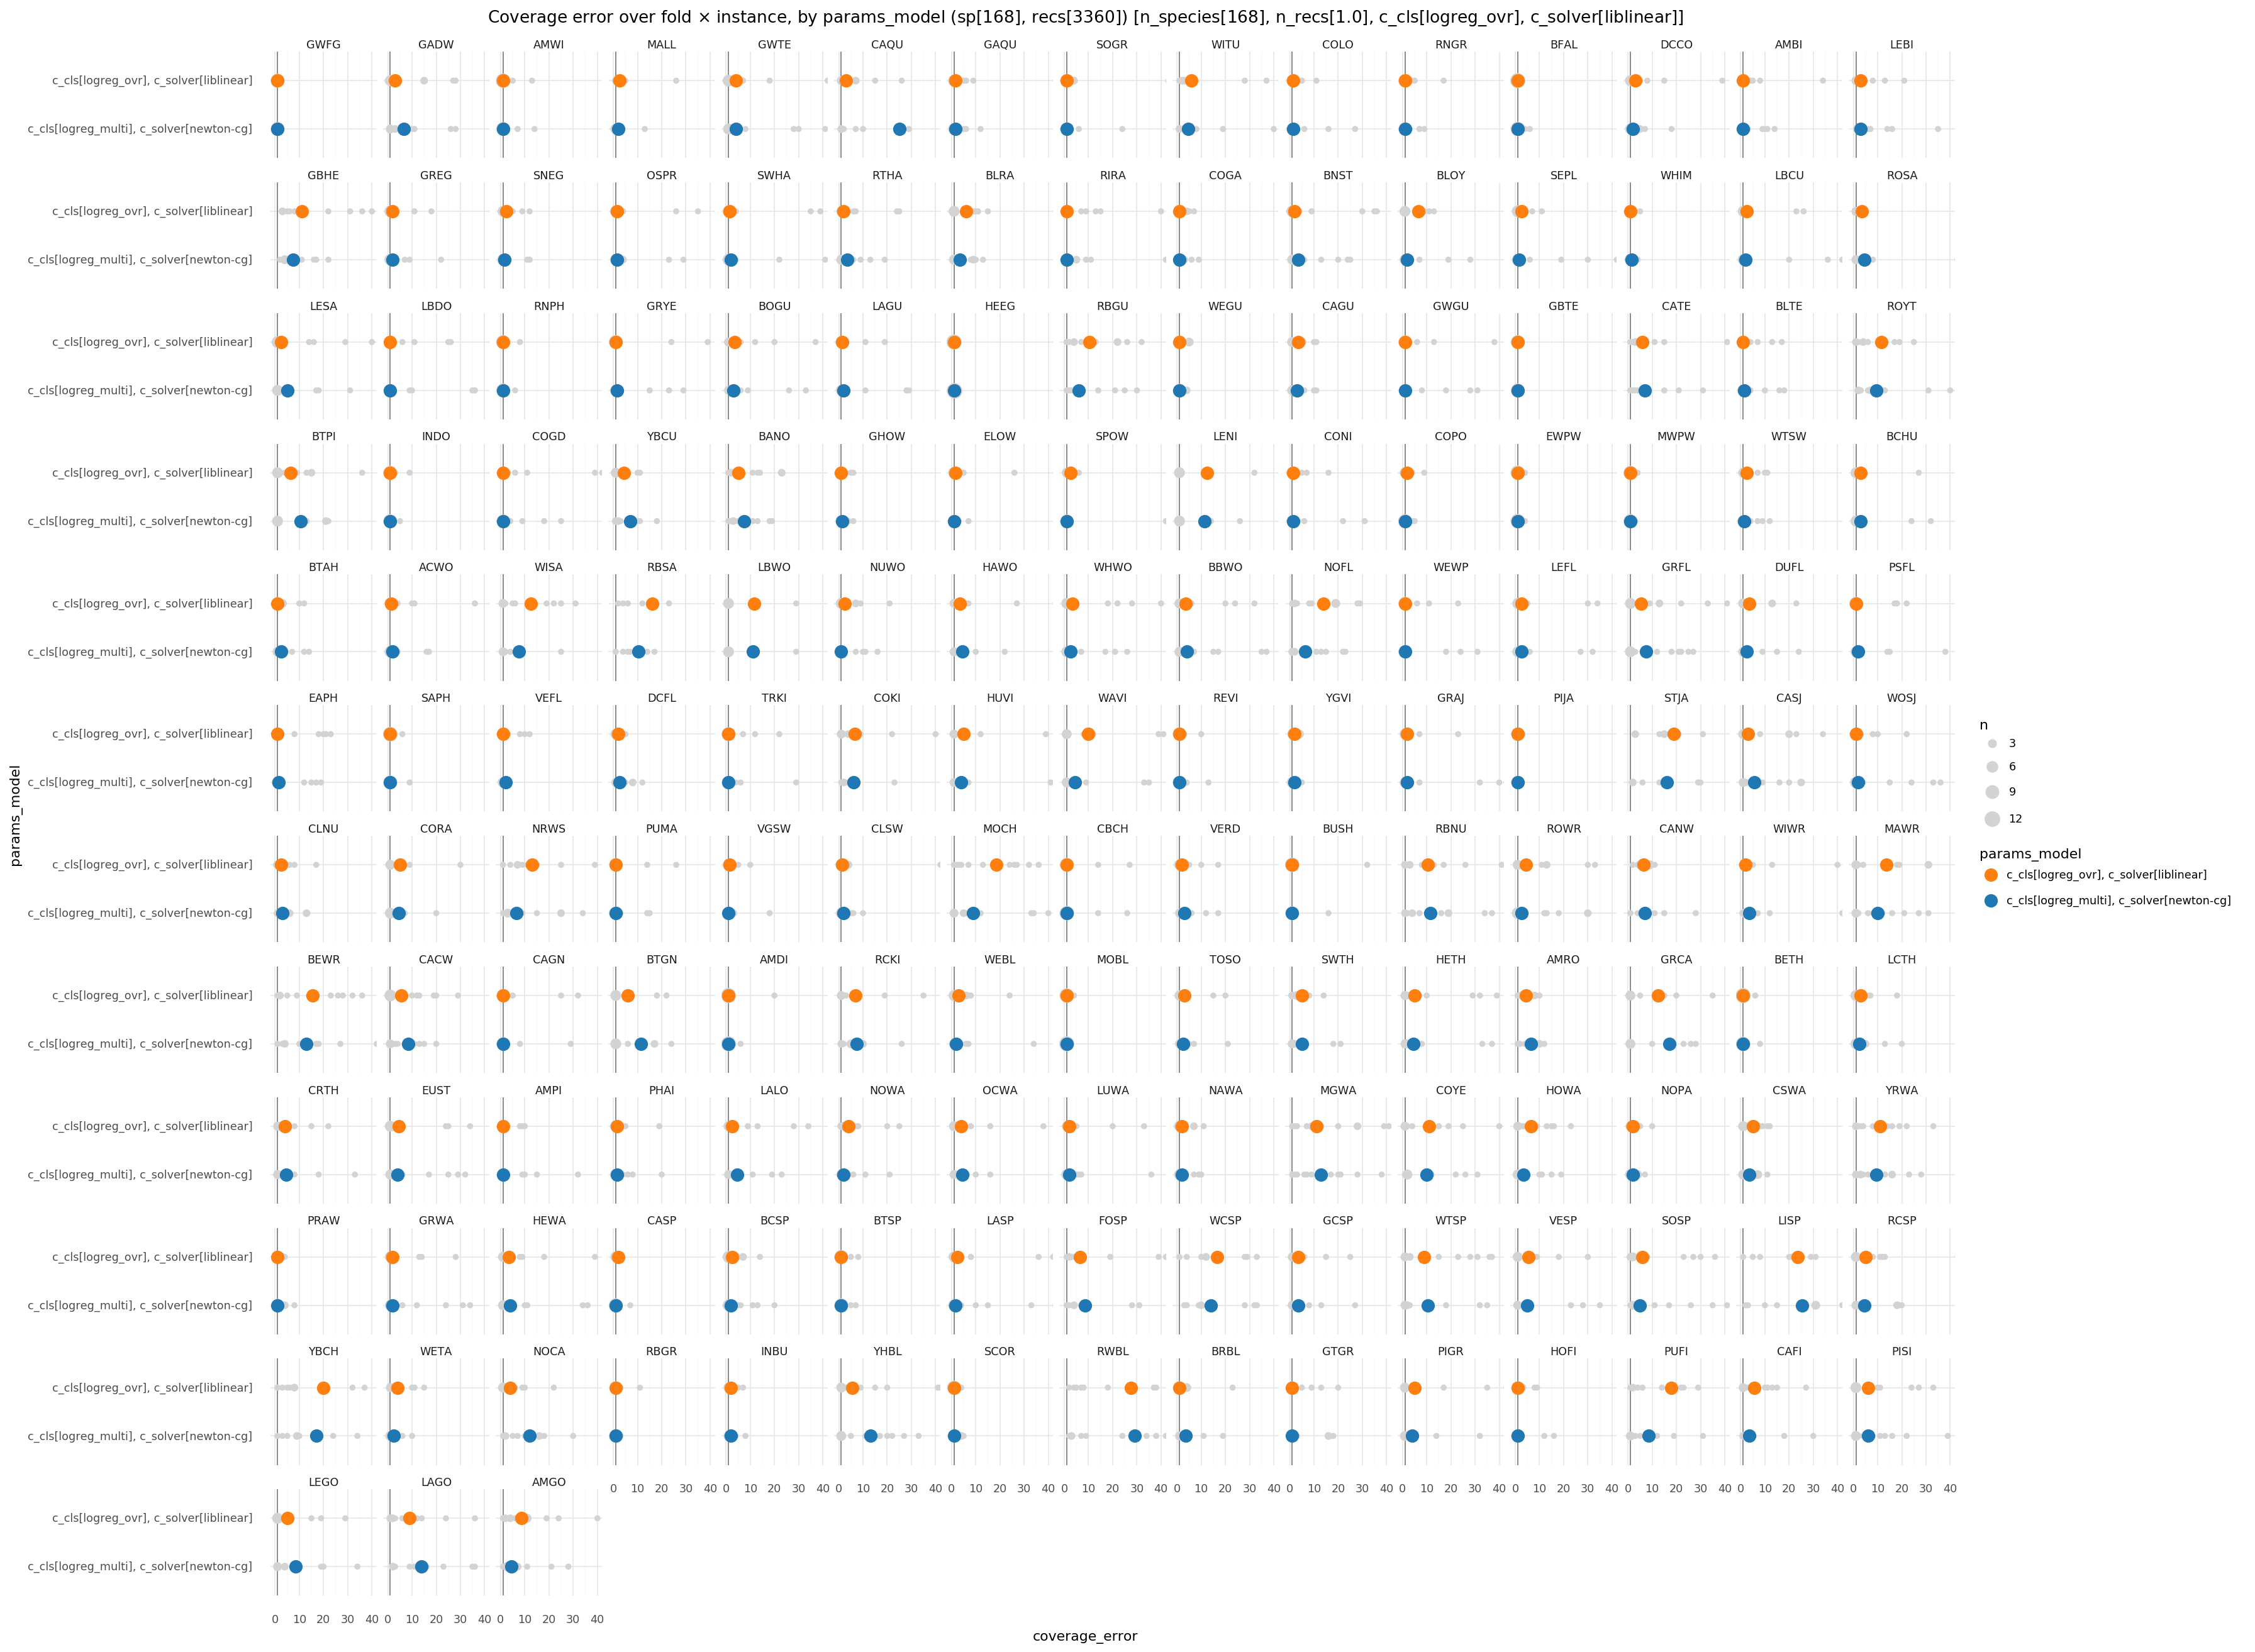

<ggplot: (8766987855357)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
# params_complexity = 'c_max_depth[46]'
params_complexity = 'c_C[0.01]'
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_complexity == params_complexity]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'params_model')
    .pipe(ggplot)
    + aes(x='params_model', y='coverage_error')
    + aes(color='params_model')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    + scale_color_cmap_d('tab10')  # Strong
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=24, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_model ({recs_stats}) [{params_data}, {params_model}]')
)

In [ ]:
ONE_MODEL_PLOTS_NEXT

NameError: name 'ONE_MODEL_PLOTS_NEXT' is not defined

# Model diagnostics: one model, all folds

In [ ]:
params_i = 0
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

params:
  0: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]'
  1: 'n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.01]'
  2: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]'
  3: 'n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.1]'
  4: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[1]'
  5: 'n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[1]'
  6: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[10]'
  7: 'n_species[168], n_recs[1.0], c_cls[logreg_multi], c_solver[newton-cg], c_C[10]'
  8: 'n_species[168], n_recs[0.5], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]'
  9: 'n_species[168], n_recs[0.5], c_cls[logreg_multi], c_solver[newton-cg], c_C[0.01]'
  10: 'n_species[168], n_recs[0.5], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]'
  11: 'n_species[168], n_recs[0.5], c_cls[logreg

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:5],
)

min  \
                  dtype    sizeof len  count nunique mean     std                                                                                                
model_id          category 274176 2016 2016  3       NaN      NaN      n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
params            category 256032 2016 2016  1       NaN      NaN               n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]   
params_data       category 379008 2016 2016  1       NaN      NaN                                                                  n_species[168], n_recs[1.0]   
params_model      category 489888 2016 2016  1       NaN      NaN                                                       c_cls[logreg_ovr], c_solver[liblinear]   
params_complexity category 197568 2016 2016  1       NaN      NaN                                                                                    c_C[0.01]   
fold              int64    53760  2016 2016  3       1.000    0.817                                                                                          0   
i                 int64    56448  2016 2016  1642    1678.547 968.840                                                                                        1   
y_true            object   174720 2016 2016  168     NaN      NaN                                                                                         ACWO   
coverage_error    float64  48384  2016 2016  132     13.047   25.136                                                                                         1   

                                                                                                                                                           25%  \
                  dtype    sizeof len  count nunique mean     std                                                                                                
model_id          category 274176 2016 2016  3       NaN      NaN      n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
params            category 256032 2016 2016  1       NaN      NaN               n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]   
params_data       category 379008 2016 2016  1       NaN      NaN                                                                  n_species[168], n_recs[1.0]   
params_model      category 489888 2016 2016  1       NaN      NaN                                                       c_cls[logreg_ovr], c_solver[liblinear]   
params_complexity category 197568 2016 2016  1       NaN      NaN                                                                                    c_C[0.01]   
fold              int64    53760  2016 2016  3       1.000    0.817                                                                                          0   
i                 int64    56448  2016 2016  1642    1678.547 968.840                                                                                      837   
y_true            object   174720 2016 2016  168     NaN      NaN                                                                                         CONI   
coverage_error    float64  48384  2016 2016  132     13.047   25.136                                                                                         1   

                                                                                                                                                           50%  \
                  dtype    sizeof len  count nunique mean     std                                                                                                
model_id          category 274176 2016 2016  3       NaN      NaN      n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[1]   
params            category 256032 2016 2016  1       NaN      NaN               n_species[168], n_recs[

model_id  \
0  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
1  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
2  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
3  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   
4  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01], fold[0]   

                                                                           params                  params_data  \
0  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
1  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
2  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
3  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   
4  n_species[168], n_recs[1.0], c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]  n_species[168], n_recs[1.0]   

                             params_model params_complexity  fold     i y_true  coverage_error  
0  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  1335   HAWO             1.0  
1  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  1219   BTAH             3.0  
2  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  1159   MWPW             1.0  
3  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0  3033   WETA             1.0  
4  c_cls[logreg_ovr], c_solver[liblinear]         c_C[0.01]     0   635   LBDO            26.0

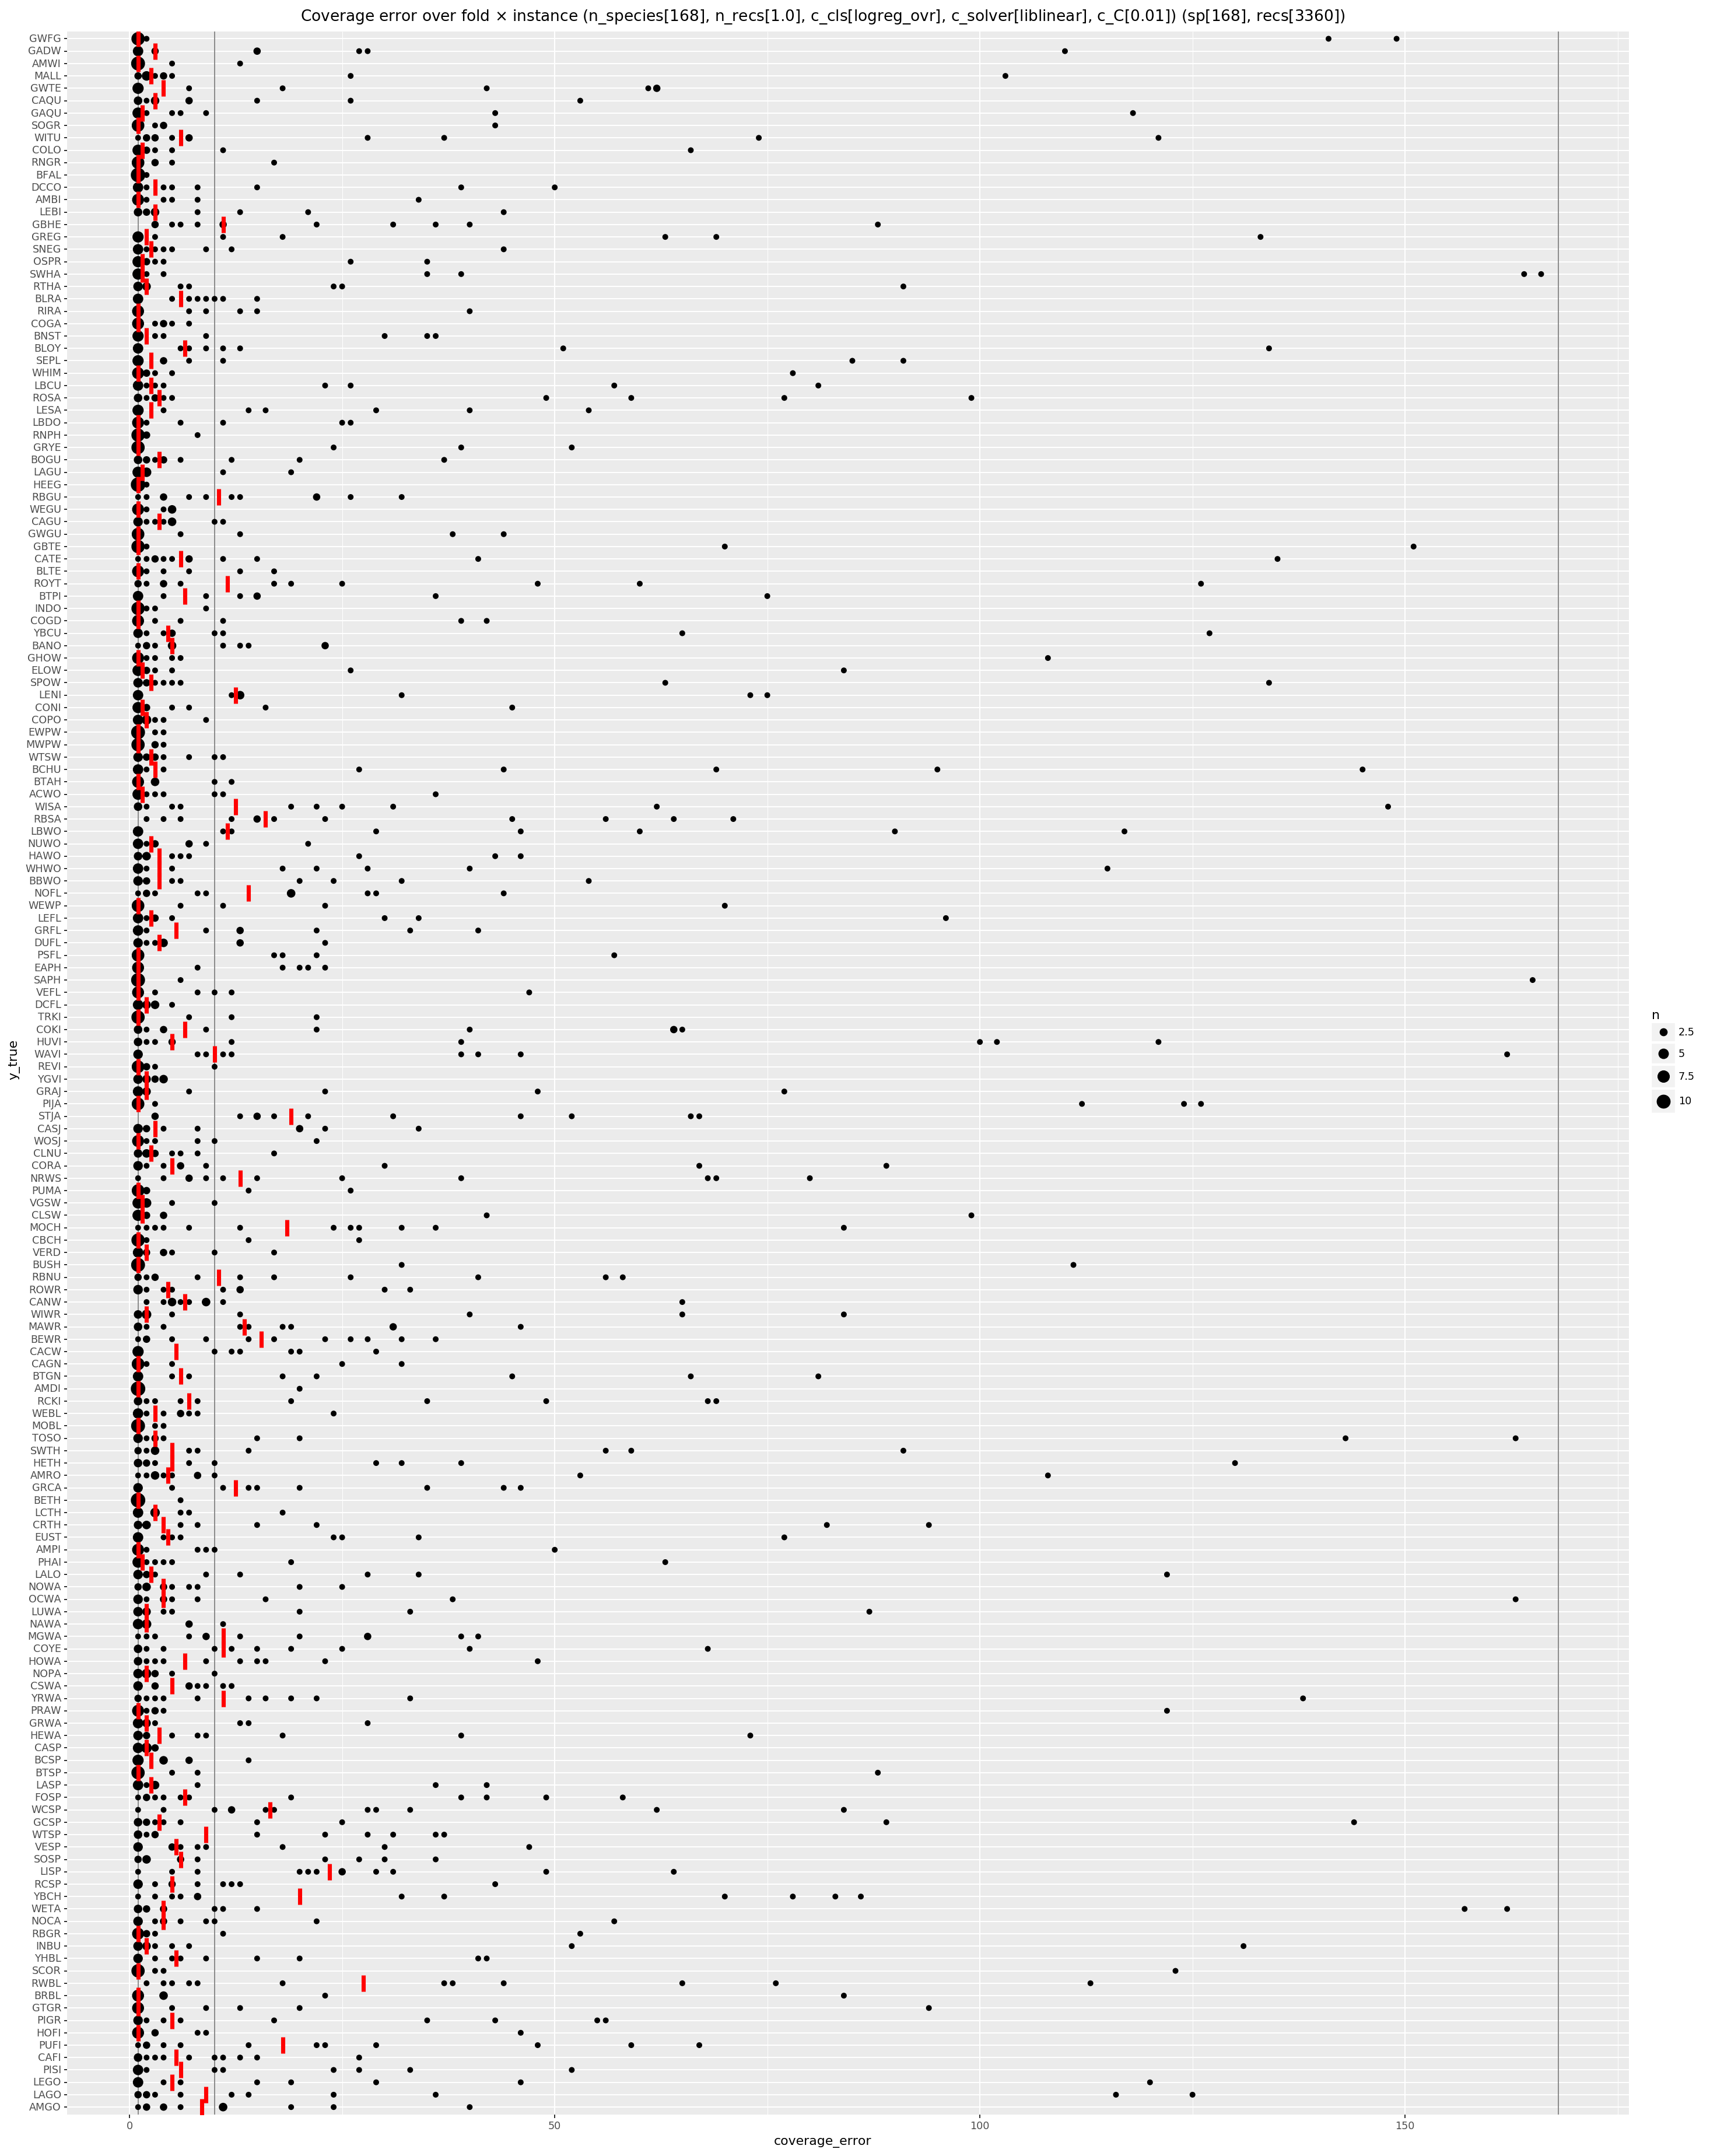

<ggplot: (8766710239759)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=10, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

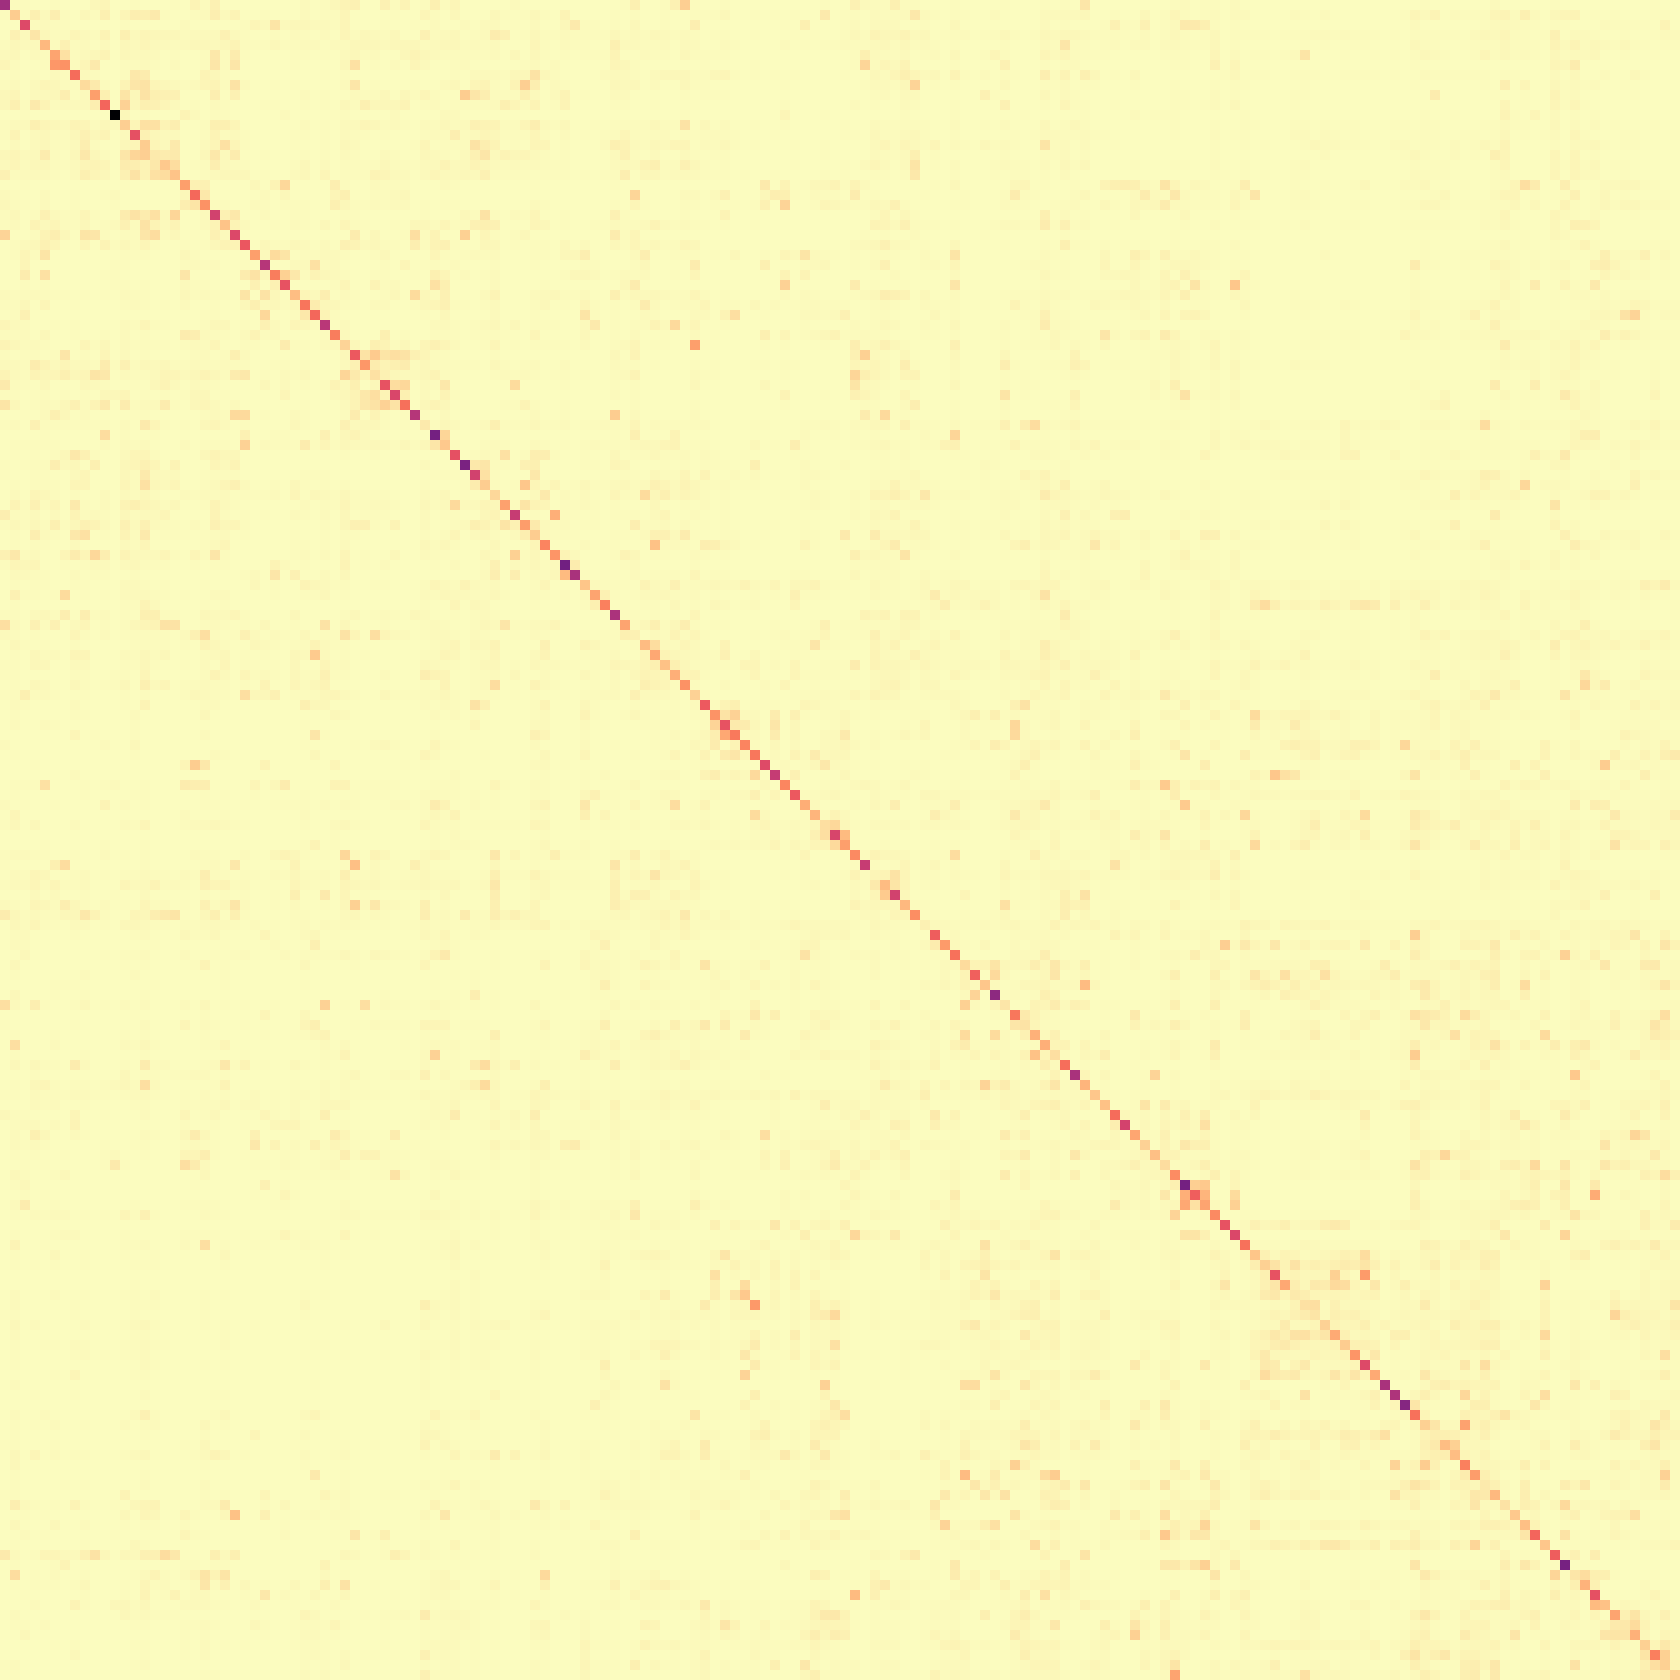

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]